# Load Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy
from datetime import datetime,timedelta
from xmovie import Movie
import nfft
import xrft
import cmath
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import math
from math import radians, cos, sin, asin, sqrt
import xeofs
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%run Code_functions.ipynb
%matplotlib inline

/home/hgrosselindemann/miniconda3/envs/xesmf_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# input_path = 'E:/for_hendrik_20230316/'
# figure_path = '/Users/2311043/Documents/GitHub/TORI/figures/'

input_path = '/home/hgrosselindemann/Documents/TORI/'
figure_path = '/home/hgrosselindemann/Documents/GitHub/TORI/figures/'

# velocity = xr.open_mfdataset(input_path + 'velocity_raw_detrended.nc')
velocity = xr.open_dataset(input_path + 'velocity_raw_filtered.nc')

# spectral_u = xr.open_dataset(input_path + 'spectral_u.nc')
# spectral_u['f_k'] = spectral_u.f_k_real + 1j*spectral_u.f_k_imag

# spectral_v = xr.open_dataset(input_path + 'spectral_v.nc')
# spectral_v['f_k'] = spectral_v.f_k_real + 1j*spectral_v.f_k_imag

# spectral_rotary = xr.open_dataset(input_path + 'spectral_rotary.nc')
# spectral_rotary['f_k'] = spectral_rotary.f_k_real + 1j*spectral_rotary.f_k_imag

bathy = xr.open_dataset(input_path + 'etopo5.cdf')
bathy = bathy.rename({'ETOPO05_X': 'lon', 'ETOPO05_Y': 'lat'})
bathy = bathy.where(bathy.ROSE <= 0)

In [2]:
# input_path = '/home/hgrosselindemann/Documents/for_hendrik_20230316/'

# input_path = '/Users/2311043/Documents/GitHub/TORI/'
input_path = 'E:/for_hendrik_20230316/'

grid_data = scipy.io.loadmat(input_path + 'TOROS_grids_f.mat')
# vel_data = scipy.io.loadmat(input_path + '201503.mat')

In [3]:
time = np.arange(datetime(2013,1,1,0,0,0), datetime(2018,1,1,0,0,0), timedelta(hours=1)).astype(datetime)

In [8]:
files = []
months = ['01','02','03','04','05','06','07','08','09','10','11','12']
for year in np.arange(2013,2018):
    for month in months:

        files.append(input_path + 'raw_data/' + f'{year}{month}.mat')

In [9]:
vel_u = scipy.io.loadmat(files[0])['u0_monthly']
vel_v = scipy.io.loadmat(files[0])['v0_monthly']


for file in files[1:]:
    u = scipy.io.loadmat(file)['u0_monthly']
    v = scipy.io.loadmat(file)['v0_monthly']

    vel_u = np.concatenate((vel_u,u),axis=-1)
    vel_v = np.concatenate((vel_v,v),axis=-1)

In [10]:
flag = xr.Dataset(coords={
    'lat':(['y','x'],grid_data['lat0']),
    'lon':(['y','x'],grid_data['lon0'])
},data_vars={
    'flag':(['y','x'],grid_data['flag0'])
})

velocity = xr.Dataset(coords={
    'lat':(['y','x'],grid_data['lat0']),
    'lon':(['y','x'],grid_data['lon0']),
    'time':(['time'],time)
},data_vars={
    'u':(['y','x','time'],vel_u/100),
    'v':(['y','x','time'],vel_v/100)
})

velocity = velocity.transpose('time','y','x')

velocity['u'] = velocity['u'].where(flag.flag==0)
velocity['v'] = velocity['v'].where(flag.flag==0)
velocity['abs'] = np.sqrt(velocity['u']**2 + velocity['v']**2)

# means

In [392]:
u_dashed = velocity.u - velocity.u.mean(dim='time')
v_dashed = velocity.v - velocity.v.mean(dim='time')

eke_mean = ((u_dashed**2).mean(dim='time') + (v_dashed**2).mean(dim='time'))/2

In [11]:
eke = (velocity.u**2 + velocity.v**2)/2 - (velocity.u.mean(dim='time')**2 + velocity.v.mean(dim='time')**2)/2

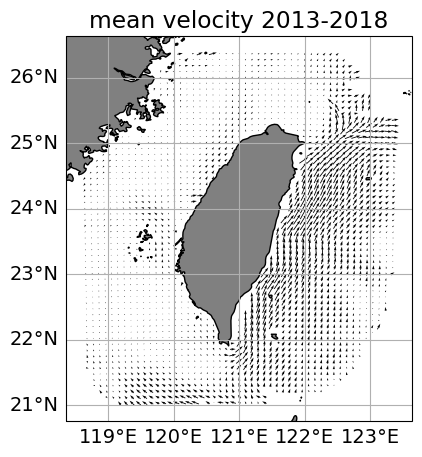

In [89]:
# fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,5),
#                        subplot_kw={'projection': ccrs.PlateCarree()})

fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5), 
                          subplot_kw={'projection': ccrs.PlateCarree()})

# eke_mean.plot(ax=ax1,x='lon',y='lat',cmap=cmo.amp,cbar_kwargs={'label':'EKE'})
velocity.mean(dim='time').plot.quiver('lon','lat','u','v',ax=ax1,add_guide=False)
ax1.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False
ax1.set_title('mean velocity 2013-2018')
plt.savefig(figure_path + 'mean_velocity.png')

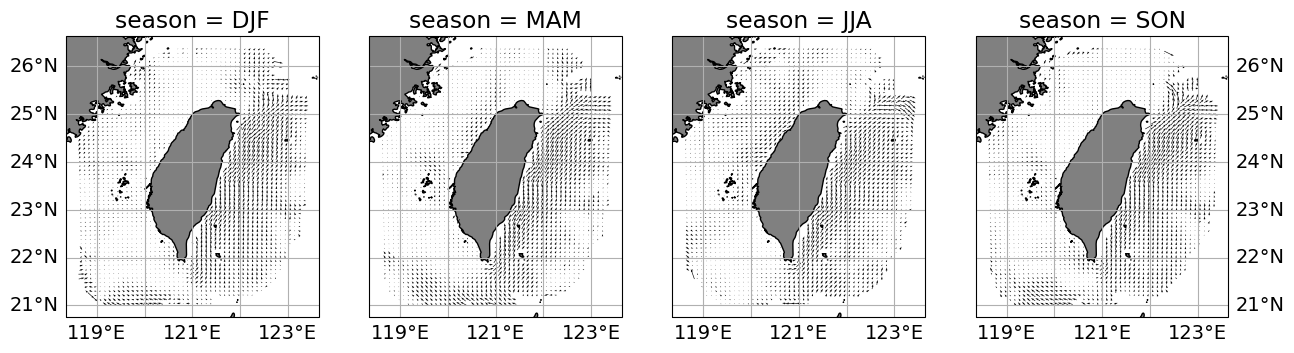

In [90]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})

season_mean = velocity.groupby('time.season').mean()
season_mean.sel(season='DJF').plot.quiver('lon','lat','u','v',ax=ax1,add_guide=False)
season_mean.sel(season='MAM').plot.quiver('lon','lat','u','v',ax=ax2,add_guide=False)
season_mean.sel(season='JJA').plot.quiver('lon','lat','u','v',ax=ax3,add_guide=False)
season_mean.sel(season='SON').plot.quiver('lon','lat','u','v',ax=ax4,add_guide=False)

ax1.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False

ax2.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl2 = ax2.gridlines(draw_labels=True)
gl2.top_labels=False
gl2.right_labels=False
gl2.left_labels=False

ax3.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl3 = ax3.gridlines(draw_labels=True)
gl3.top_labels=False
gl3.right_labels=False
gl3.left_labels=False

ax4.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl4 = ax4.gridlines(draw_labels=True)
gl4.top_labels=False
gl4.left_labels=False

plt.savefig(figure_path + 'seasonal_means.png')

# Data Coverage

In [180]:
nan_mask = ~np.isnan(velocity.u)
data_coverage = np.sum(nan_mask,axis=0)/len(velocity.time)
velocity['coverage'] = data_coverage
velocity['coverage'] = velocity['coverage'].where(velocity.coverage!=0)

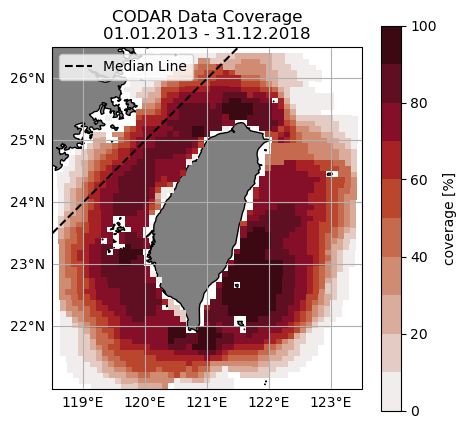

In [23]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5),
                          subplot_kw={'projection': ccrs.PlateCarree()})

(velocity.coverage*100).plot(ax=ax1, x='lon', y='lat',
                             levels=np.arange(0, 110, 10), cmap=cmo.amp,
                             cbar_kwargs={'label': 'coverage [%]'})
plt.plot([118, 122], [23, 27], color='k', transform=ccrs.PlateCarree(),
         label='Median Line', linestyle='--')

ax1.add_feature(cfeature.LAND, facecolor='grey', edgecolor='black')
# ax1.coastlines()
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels = False
gl1.right_labels = False
ax1.set_extent([118.5, 123.5, 21, 26.5])
ax1.legend(loc='upper left')
# for x,y in zip(x_idx,y_idx):
#     xr.plot.scatter(ds=velocity.isel(x=x,y=y),x='lon',y='lat',color='b')
# xr.plot.scatter(ds=velocity.isel(x=28,y=10),x='lon',y='lat')
# plt.scatter(longitudes,latitudes,transform=ccrs.PlateCarree(),marker='x')
ax1.set_title('CODAR Data Coverage\n01.01.2013 - 31.12.2018')
plt.savefig(figure_path + 'data_coverage.png')

# De-mean and De-trend

In [54]:
velocity['u_demeaned'],velocity['u_mean'] = demean_xarray(velocity.u,dim='time')
velocity['v_demeaned'],velocity['v_mean'] = demean_xarray(velocity.v,dim='time')

In [63]:
velocity['u_detrended'],velocity['u_trend'] = detrend_xarray(velocity['u_demeaned'])
velocity['v_detrended'],velocity['v_trend'] = detrend_xarray(velocity['v_demeaned'])

In [65]:
velocity.to_netcdf(input_path + 'velocity_raw_detrended.nc')

# interpolation

In [22]:
test = velocity.u[:,10,10].copy()
dummy = test.interpolate_na(dim='time',method='linear')

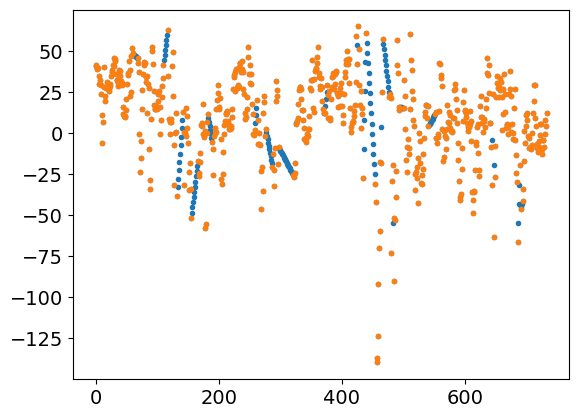

In [23]:
plt.plot(dummy,'.')
plt.plot(test,'.')


# Spectral analysis

## uniform FFT

In [36]:
mask = ~np.isnan(u_detrended[:,10,10].interpolate_na(dim='time',method='linear'))
freq,ps,psd = spectrum1(u_detrended[:,10,10].interpolate_na(dim='time',method='linear')[mask])

## non-uniform FFT

In [5]:
# spectral_u = spectral_analysis(velocity.u_detrended)
spectral_v = spectral_analysis(velocity.v_detrended)

spectral_v = spectral_v.where(spectral_v!=0)

spectral_v_nocomplex = spectral_v.copy()

spectral_v_nocomplex['f_k_real'] = np.real(spectral_v_nocomplex.f_k)
spectral_v_nocomplex['f_k_imag'] = np.imag(spectral_v_nocomplex.f_k)

spectral_v_nocomplex = spectral_v_nocomplex.drop(['f_k'])

spectral_v_nocomplex.to_netcdf(input_path + 'spectral_v.nc')

In [60]:
freq,f_k,ps,psd,t = nufft(velocity.u_detrended[:,12,28],xarray_apply=False)
# freq,f_k_filtered,ps_filtered,psd_filtered,data_reconstructed_filtered = nufft(velocity.u_filtered[:,12,28],xarray_apply=False)

In [70]:
freq_hann,f_k_hann,ps_hann,psd_hann,t_hann = nufft(velocity.v_detrended[:,12,28],xarray_apply=False)

In [20]:
freq_pos = freq[372:]

f_k_pos = np.ones((372))*f_k[372:]
f_k_pos[1:] = f_k_pos[1:]*2

ps_pos = np.ones((372))*ps[372:]
ps_pos[1:] = ps_pos[1:]*2

psd_pos = np.ones((372))*psd[372:]
psd_pos[1:] = psd_pos[1:]*2

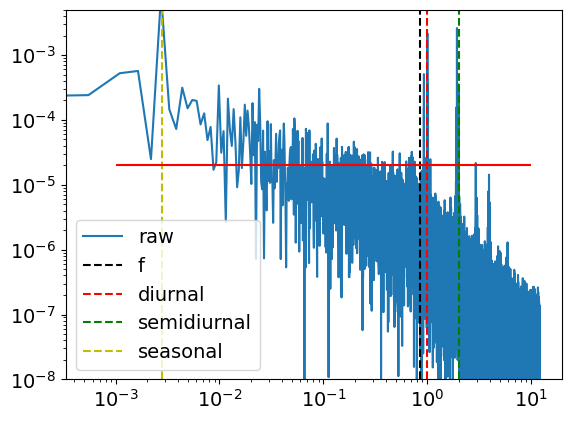

In [62]:
f_coriolis = 2*7.29e-5*np.sin(25/180*np.pi)/2/np.pi*3600*24

plt.loglog(freq*24,ps,label='raw')

# plt.loglog(spectral_u.freq*24,spectral_u.isel(x=28,y=12).ps,label='filtered')
# plt.loglog(spectral_u.freq*24,spectral_u.isel(x=12,y=28).ps,label='filtered')


# plt.loglog(spectral_u.freq*24,spectral_u.isel(x=10,y=10).ps,label='filtered')
# plt.loglog(spectral_u.isel(x=28,y=12).sel(freq=slice(9e-1/24,1.1/24)).freq*24,spectral_u.isel(x=28,y=12).sel(freq=slice(9e-1/24,1.1/24)).ps)
# plt.loglog(spectral_u_hann.isel(x=10,y=10).freq*24,spectral_u_hann.isel(x=10,y=10).ps,label='hann')
# plt.loglog(spectral_u.isel(x=10,y=10).freq*24,spectral_u.isel(x=10,y=10).ps,label='detrend')

ymin,ymax = 1e-8,5e-3
plt.vlines([f_coriolis],ymin,ymax,color=['k'],linestyle='--',label='f')
plt.vlines([1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')
plt.vlines([2],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')
plt.vlines([2.8e-3],ymin,ymax,color=['y'],linestyle='--',label='seasonal')

# plt.vlines(spectral_u.freq[test[0]+idx].data*24,ymin,ymax,color='k')
plt.legend(loc='lower left')
plt.ylim([ymin,ymax]);

plt.hlines(2e-5,1e-3,10,color='r')
plt.savefig(figure_path + '/spectrum_example.png')

## Rotary spectrum

In [5]:
spectral_rotary = spectral_analysis(velocity.u_detrended+1j*velocity.v_detrended)

spectral_rotary = spectral_rotary.where(spectral_rotary!=0)

spectral_rotary_nocomplex = spectral_rotary.copy()

spectral_rotary_nocomplex['f_k_real'] = np.real(spectral_rotary_nocomplex.f_k)
spectral_rotary_nocomplex['f_k_imag'] = np.imag(spectral_rotary_nocomplex.f_k)

spectral_rotary_nocomplex = spectral_rotary_nocomplex.drop(['f_k'])

spectral_rotary_nocomplex.to_netcdf(input_path + 'spectral_rotary.nc')

In [63]:
freq,f_k,ps,psd,t = nufft(velocity.u_detrended[:,12,28]+1j*velocity.v_detrended[:,12,28],xarray_apply=False)
# freq,f_k_filtered,ps_filtered,psd_filtered,t = nufft(velocity.u_filtered[:,10,10]+1j*velocity.v_filtered[:,10,10],xarray_apply=False)

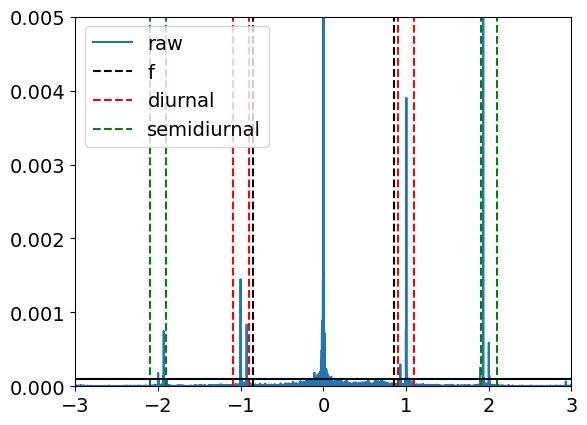

In [66]:
f_coriolis = 2*7.29e-5*np.sin(25/180*np.pi)/2/np.pi*3600*24

# plt.plot(spectral_rotary.freq*24,spectral_rotary.isel(x=10,y=10).ps,label='raw')
plt.plot(freq*24,ps,label='raw')

plt.xlim([-3,3])
ymin,ymax = 0,0.005
plt.vlines([f_coriolis,-f_coriolis],ymin,ymax,color=['k'],linestyle='--',label='f')
# plt.vlines([1,-1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')
plt.vlines([0.9,1.1,-0.9,-1.1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')
# plt.vlines([-0.9,-1.1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')

# plt.vlines([2,-2],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')
plt.vlines([2.1,-2.1,1.9,-1.9],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')
# plt.vlines([1.9,-1.9],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')

plt.hlines(1e-4,-3,3,color='k')
plt.legend()
plt.ylim([ymin,ymax]);

plt.savefig(figure_path + 'spectrum_example_rotary.png')

## find peaks

In [5]:
# diurnal_u = find_peaks_xr(spectral_u,freq_min=0.9/24,freq_max=1.1/24,peak_height=2e-5)
# semidiurnal_u = find_peaks_xr(spectral_u,freq_min=1.9/24,freq_max=2.1/24,peak_height=2e-5)

diurnal_v = find_peaks_xr(spectral_v,freq_min=0.9/24,freq_max=1.1/24,peak_height=2e-5)
semidiurnal_v = find_peaks_xr(spectral_v,freq_min=1.9/24,freq_max=2.1/24,peak_height=2e-5)

C:\Users\2311043\AppData\Local\Temp\ipykernel_14756\1391194171.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([freq_max,peak_max])


### u

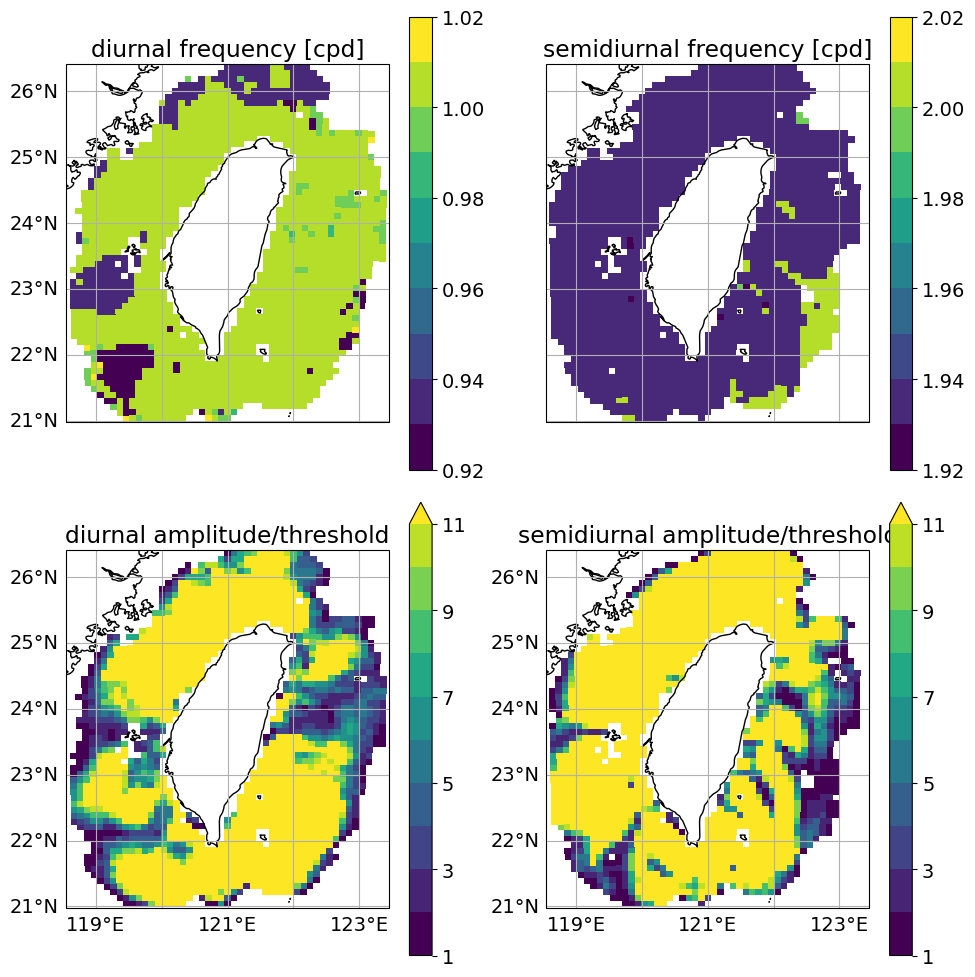

In [8]:
fig, axs = plt.subplots(2,2,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()},sharex=True,sharey=True)
axs=axs.ravel()
(diurnal_u[:,:,0]*24).plot(x='lon',y='lat',ax=axs[0],levels=np.arange(0.92,1.03,0.01))
(diurnal_u[:,:,1]/2e-5).plot(x='lon',y='lat',ax=axs[2],levels=np.arange(1,12,1))

(semidiurnal_u[:,:,0]*24).plot(x='lon',y='lat',ax=axs[1],levels=np.arange(1.92,2.03,0.01))
(semidiurnal_u[:,:,1]/2e-5).plot(x='lon',y='lat',ax=axs[3],levels=np.arange(1,12,1))

for ax in axs:
    ax.coastlines()
gl0 = axs[0].gridlines(draw_labels=True)
gl0.top_labels=False;gl0.right_labels=False;gl0.bottom_labels=False

gl1 = axs[1].gridlines(draw_labels=True)
gl1.top_labels=False;gl1.right_labels=False;gl1.bottom_labels=False;gl1.left_labels=False

gl2 = axs[2].gridlines(draw_labels=True)
gl2.top_labels=False;gl2.right_labels=False

gl3 = axs[3].gridlines(draw_labels=True)
gl3.top_labels=False;gl3.right_labels=False

fig.tight_layout()
axs[0].set_title('diurnal frequency [cpd]'),axs[1].set_title('semidiurnal frequency [cpd]')
axs[2].set_title('diurnal amplitude/threshold'),axs[3].set_title('semidiurnal amplitude/threshold')

plt.savefig(figure_path + 'tides_u.png')

### v

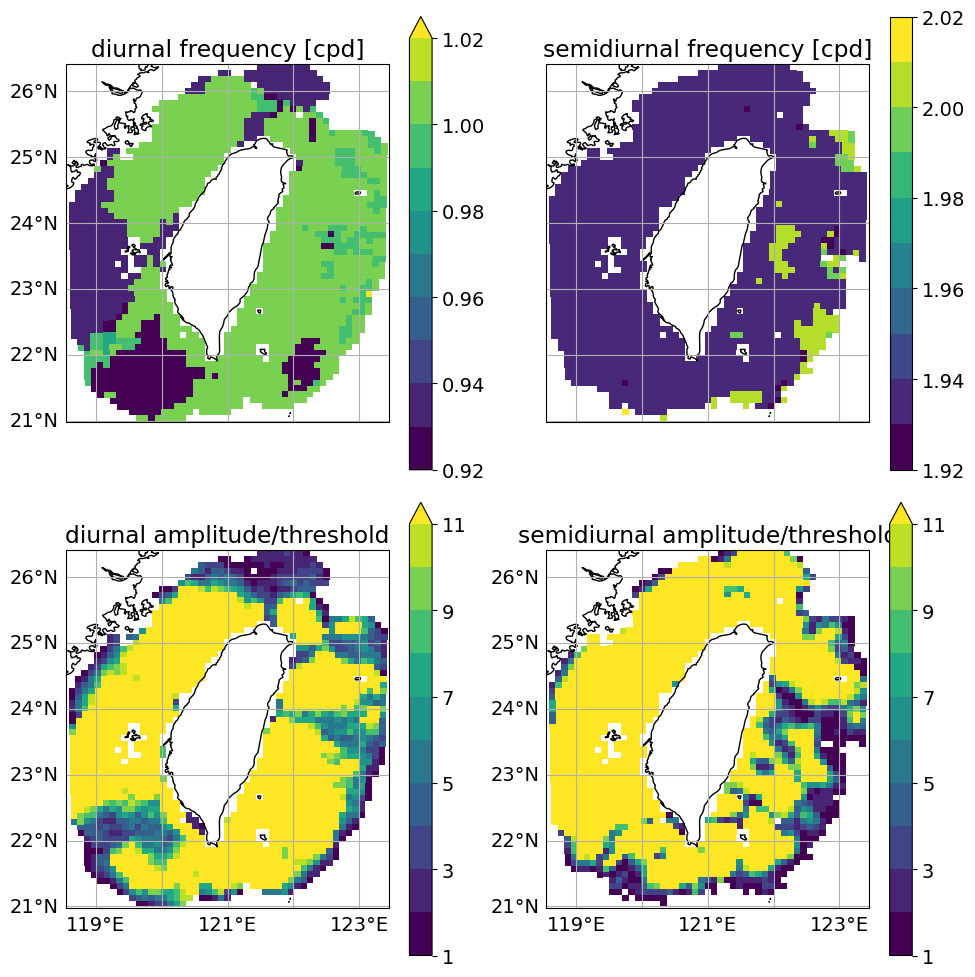

In [6]:
fig, axs = plt.subplots(2,2,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()},sharex=True,sharey=True)
axs=axs.ravel()
(diurnal_v[:,:,0]*24).plot(x='lon',y='lat',ax=axs[0],levels=np.arange(0.92,1.03,0.01))
(diurnal_v[:,:,1]/2e-5).plot(x='lon',y='lat',ax=axs[2],levels=np.arange(1,12,1))

(semidiurnal_v[:,:,0]*24).plot(x='lon',y='lat',ax=axs[1],levels=np.arange(1.92,2.03,0.01))
(semidiurnal_v[:,:,1]/2e-5).plot(x='lon',y='lat',ax=axs[3],levels=np.arange(1,12,1))

for ax in axs:
    ax.coastlines()
gl0 = axs[0].gridlines(draw_labels=True)
gl0.top_labels=False;gl0.right_labels=False;gl0.bottom_labels=False

gl1 = axs[1].gridlines(draw_labels=True)
gl1.top_labels=False;gl1.right_labels=False;gl1.bottom_labels=False;gl1.left_labels=False

gl2 = axs[2].gridlines(draw_labels=True)
gl2.top_labels=False;gl2.right_labels=False

gl3 = axs[3].gridlines(draw_labels=True)
gl3.top_labels=False;gl3.right_labels=False

fig.tight_layout()
axs[0].set_title('diurnal frequency [cpd]'),axs[1].set_title('semidiurnal frequency [cpd]')
axs[2].set_title('diurnal amplitude/threshold'),axs[3].set_title('semidiurnal amplitude/threshold')

plt.savefig(figure_path + 'tides_v.png')

### rot

In [5]:
diurnal_rot = find_peaks_rot_xr(spectral_rotary,freq_min=0.9/24,freq_max=1.1/24,peak_height=1e-4)
semidiurnal_rot = find_peaks_rot_xr(spectral_rotary,freq_min=1.9/24,freq_max=2.1/24,peak_height=1e-4)

C:\Users\2311043\AppData\Local\Temp\ipykernel_1496\1449752959.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([freq_max,peak_max])


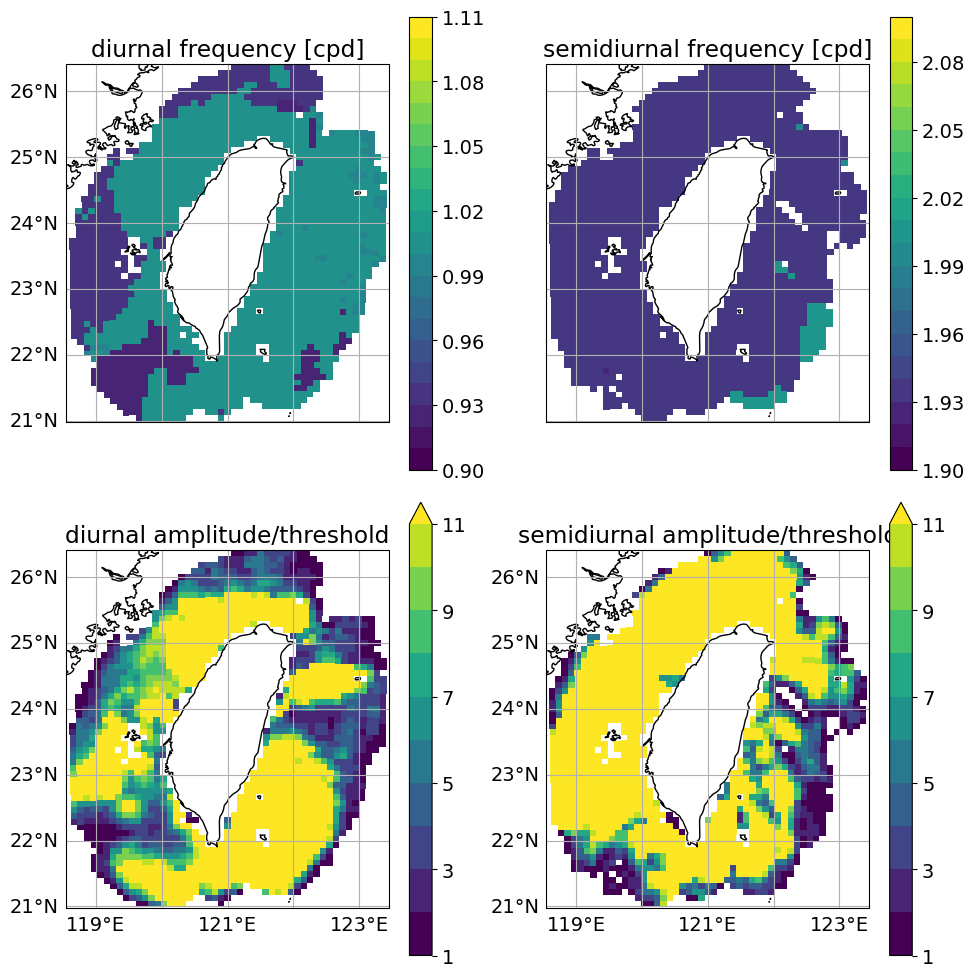

In [6]:
fig, axs = plt.subplots(2,2,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()},sharex=True,sharey=True)
axs=axs.ravel()
(diurnal_rot[:,:,0]*24).plot(x='lon',y='lat',ax=axs[0],levels=np.arange(0.9,1.11,0.01))
(diurnal_rot[:,:,1]/1e-4).plot(x='lon',y='lat',ax=axs[2],levels=np.arange(1,12,1))

(semidiurnal_rot[:,:,0]*24).plot(x='lon',y='lat',ax=axs[1],levels=np.arange(1.9,2.11,0.01))
(semidiurnal_rot[:,:,1]/1e-4).plot(x='lon',y='lat',ax=axs[3],levels=np.arange(1,12,1))

for ax in axs:
    ax.coastlines()
gl0 = axs[0].gridlines(draw_labels=True)
gl0.top_labels=False;gl0.right_labels=False;gl0.bottom_labels=False

gl1 = axs[1].gridlines(draw_labels=True)
gl1.top_labels=False;gl1.right_labels=False;gl1.bottom_labels=False;gl1.left_labels=False

gl2 = axs[2].gridlines(draw_labels=True)
gl2.top_labels=False;gl2.right_labels=False

gl3 = axs[3].gridlines(draw_labels=True)
gl3.top_labels=False;gl3.right_labels=False

fig.tight_layout()
axs[0].set_title('diurnal frequency [cpd]'),axs[1].set_title('semidiurnal frequency [cpd]')
axs[2].set_title('diurnal amplitude/threshold'),axs[3].set_title('semidiurnal amplitude/threshold')

plt.savefig(figure_path + 'tides_rot.png')

# tidal ellipse

In [430]:
value,f_index = find_nearest(spectral_rotary.freq*24,1)

In [436]:
x=10;y=10
fm,fp = spectral_rotary.isel(freq=[43824-f_index[0],f_index[0]],x=x,y=y).f_k

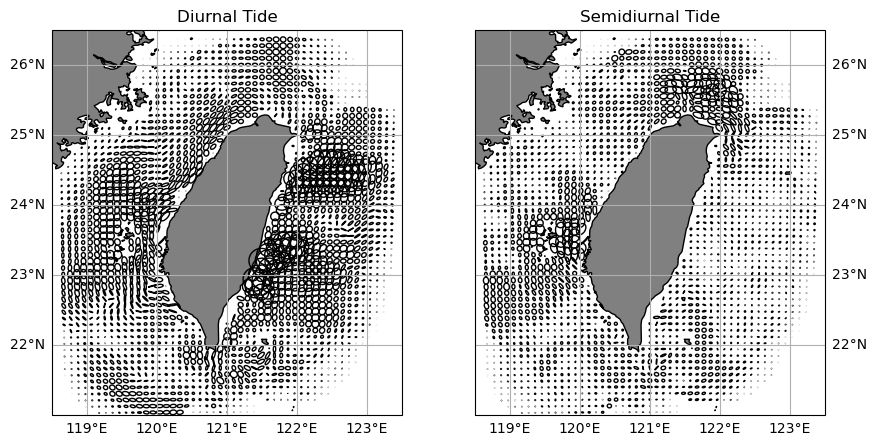

In [281]:
# f_coriolis = 2*7.29e-5*np.sin(25/180*np.pi)/2/np.pi*3600*24
# colors = ['r', 'b']
# lines = [Line2D([0], [0], color=c, linewidth=3) for c in colors]
# labels = ['CCW', 'CW']

fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

for ax, f, title in zip(axs.ravel(), [1, 1.93], ['Diurnal Tide', 'Semidiurnal Tide']):
    value, f_index = find_nearest(spectral_rotary.freq*24, f)
    for x in range(49):
        for y in range(60):
            fm, fp = spectral_rotary.isel(freq=[len(spectral_rotary.freq)-f_index[0], f_index[0]], x=x, y=y).f_k
            if ~np.isnan(np.abs(fm)):
                major, minor, azimuth = ellipse_details(fm, fp)
                lonlat = [fm.lon.data, fm.lat.data]
                # rot = int(np.abs(fp).data > np.abs(fm).data)
                ell = mpl.patches.Ellipse(xy=lonlat, width=major/2e4, height=minor/2e4, angle = azimuth*180/np.pi,fc='none',ec='k',transform=ccrs.PlateCarree())

                ax.add_patch(ell)
            else:
                continue
    ax.set_aspect('equal')
    ax.autoscale()
    ax.set_title(title)
    # ax.legend(lines,labels,loc='upper left')
    ax.set_extent([118.5, 123.5, 21, 26.5])
    ax.add_feature(cfeature.LAND, facecolor='grey', edgecolor='black')

gl1 = axs.ravel()[0].gridlines(draw_labels=True)
gl1.top_labels = False
gl1.right_labels = False

gl2 = axs.ravel()[1].gridlines(draw_labels=True)
gl2.left_labels = False
gl2.top_labels = False
plt.savefig(figure_path + 'tidal_ellipses.png')

# time filtering

you need to add mean and trend again!

In [ ]:
# u_reconstructed_hann = filter_window(spectral_u,'hanning',T=49)
# u_reconstructed_but = filter_window(spectral_u,'butterworth',fc=1/40,order=10)

v_reconstructed_hann = filter_window(spectral_v,'hanning',T=49)
v_reconstructed_but = filter_window(spectral_v,'butterworth',fc=1/40,order=10)

In [11]:
# u_filtered_but = u_reconstructed_but + velocity.u_trend + velocity.u_mean
# u_filtered_hann = u_reconstructed_hann + velocity.u_trend + velocity.u_mean

v_filtered_but = v_reconstructed_but + velocity.v_trend + velocity.v_mean
v_filtered_hann = v_reconstructed_hann + velocity.v_trend + velocity.v_mean

In [12]:
# u_filtered_but.to_netcdf(input_path + 'u_filtered_but.nc')
# u_filtered_hann.to_netcdf(input_path + 'u_filtered_hann.nc')

v_filtered_but.to_netcdf(input_path + 'v_filtered_but.nc')
v_filtered_hann.to_netcdf(input_path + 'v_filtered_hann.nc')

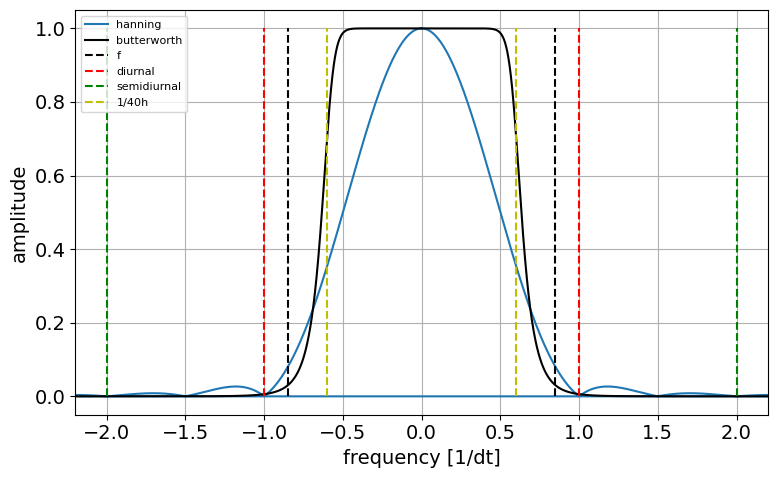

In [78]:
n = 43824

f_coriolis = 2*7.29e-5*np.sin(25/180*np.pi)/2/np.pi*3600*24

fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=True)
axs = [axs]
# axs[0].plot(freq_pos*24,ps_pos/ps_pos.max(),label='power spectrum')

for k in [24]:
    T = 2 * k + 1
#     w = np.zeros(n)
#     w[n//2 - k : n//2+k+1] = np.hanning(T)
    w = np.hanning(T)
    w = w / w.sum()
    freq_hann = np.fft.fftfreq(n)
    w_transform = np.fft.fft(w, n=n)
#     w_transform = np.ones_like(freq)
#     w_transform = (
#         0j 
#         + .5 * T * np.sinc(freq * T)
#         + .25 * T * np.sinc(T * (freq - 1 / T))
#         + .25 * T * np.sinc(T * (freq + 1 / T))
#     )
    w_transform /= w_transform[0]
    w_power = w_transform * w_transform.conj()

    plt.sca(axs[0])
    plt.plot(freq_hann*24, np.abs(w_transform),label='hanning')
    
    # plt.sca(axs[1])
    # plt.plot(freq, np.angle(w_transform), )

axs[0].set(ylabel='amplitude', xlabel='frequency [1/dt]')
axs[0].grid()



N_freq = 43824
k = -N_freq//2 + np.arange(N_freq)
freq = k/N_freq
fs = 1/3600
nyq = 0.5 * fs
fc = 1/(40*3600)
freqs = freq/3600

b,a = scipy.signal.butter(N=10,Wn=fc,btype='lowpass',fs = fs)
w, h = scipy.signal.freqz(b,a,fs=fs,worN=freqs)
plt.plot(w*3600*24, abs(h),color='k',label='butterworth')

ymin,ymax = 0,1
plt.vlines([-f_coriolis,f_coriolis],ymin,ymax,color=['k'],linestyle='--',label='f')
plt.vlines([-1,1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')
plt.vlines([-2,2],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')
plt.vlines([-24/40,24/40],ymin,ymax,color=['y'],linestyle='--',label='1/40h')

plt.legend(loc='upper left',fontsize=8)
plt.xlim([-2.2,2.2])
# axs[1].set(ylabel='phase')
# axs[1].grid()
plt.tight_layout();
plt.savefig(figure_path + 'butterworth_filter.png', bbox_inches='tight', pad_inches=.1);

In [75]:
freq,f_k,ps,psd,t = nufft(velocity.u_detrended[:,12,28],xarray_apply=False)
# fs = 1/3600
# nyq = 0.5 * fs
# fc = 1/(40*3600)
# freqs = freq/3600

# b,a = scipy.signal.butter(N=10,Wn=fc,btype='lowpass',fs = fs)
# w, h = scipy.signal.freqz(b,a,fs=fs,worN=freqs)

freq_but,amp_but = butterworth_window(43824,1/40,10)
freq_hann,amp_hann = hann_window(43824,49)


plt.semilogx(freq*24,f_k,label='raw')
plt.semilogx(freq*24,f_k*abs(amp_but),label='butterworth')
plt.semilogx(freq*24,f_k*abs(amp_hann),label='hanning')


ymin,ymax = -1500,1500
plt.vlines([24/40],ymin,ymax,color=['y'],linestyle='--',label='1/40h',linewidth=0.75)
plt.vlines([f_coriolis],ymin,ymax,color=['k'],linestyle='--',label='f',linewidth=0.75)
plt.vlines([1],ymin,ymax,color=['r'],linestyle='--',label='diurnal',linewidth=0.75)
plt.vlines([2],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal',linewidth=0.75)
plt.vlines([2.8e-3],ymin,ymax,color=['c'],linestyle='--',label='seasonal',linewidth=0.75)

plt.legend(loc='lower right',fontsize=8)

plt.xlabel('freq [cpd]')
plt.ylabel('amplitude fourier component')

plt.ylim([ymin,ymax])
plt.savefig(figure_path + 'fk_filters.png')

C:\Users\2311043\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


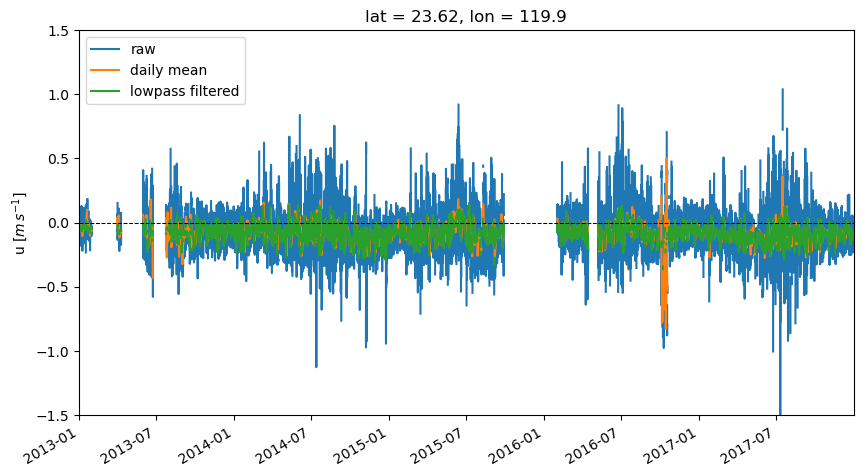

In [242]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
velocity.sel(lat=lat,lon=lon).u.plot(label='raw')
velocity_1D.sel(lat=lat,lon=lon).u.plot(label='daily mean')
velocity.sel(lat=lat,lon=lon).u_filtered.plot(label='lowpass filtered')
ax.legend()
plt.ylim([-1.5,1.5])
plt.xlim([datetime(2013,1,1),datetime(2017,12,31)])
plt.hlines(0,datetime(2013,1,1),datetime(2017,12,31),color='k',linestyle='--',linewidth=0.75)
plt.ylabel('u [$m\,s^{-1}$]')
plt.xlabel('')
plt.savefig(figure_path + 'raw_vs_filtered_example.png')

# Section Extraction

In [193]:
north_section_ = section_indices(velocity, (26, 120), (25, 121))
mid_section_ = section_indices(velocity, (24.9, 119), (24, 120.25))
south_section_ = section_indices(velocity, (23.1, 118.5), (23.1, 120))

In [194]:
north_section = extract_section(velocity, (26, 120), (25, 121))
mid_section = extract_section(velocity, (24.9, 119), (24, 120.25))
south_section = extract_section(velocity, (23.1, 118.5), (23.1, 120))

Text(0.5, 1.0, 'sections in Taiwan Strait')

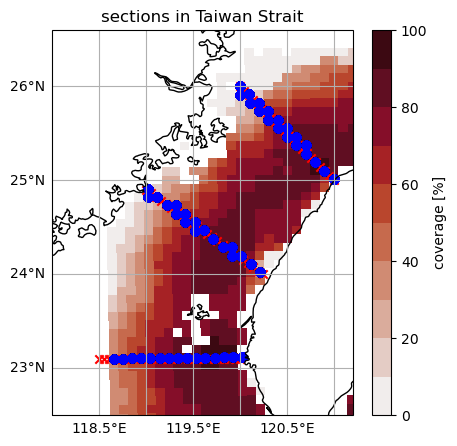

In [195]:
fig, (ax1) = plt.subplots(1,1,figsize=(5,5),subplot_kw={'projection':ccrs.PlateCarree()})

(velocity.coverage*100).plot(ax=ax1,x='lon',y='lat',levels=np.arange(0,110,10),cmap=cmo.amp,cbar_kwargs={'label':'coverage [%]'})

ax1.set_extent([118,121.2,22.5,26.6])
ax1.coastlines()
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False

plt.scatter(north_section_[3],north_section_[2],color='r',marker='x')
plt.scatter(mid_section_[3],mid_section_[2],color='r',marker='x')
plt.scatter(south_section_[3],south_section_[2],color='r',marker='x')



xr.plot.scatter(ds=north_section,x='lon',y='lat',color='b',alpha=0.5)
xr.plot.scatter(ds=mid_section,x='lon',y='lat',color='b',alpha=0.5)
xr.plot.scatter(ds=south_section,x='lon',y='lat',color='b',alpha=0.5)
# xr.plot.scatter(ds=north_section_ssh,x='lon',y='lat',color='g',alpha=0.5)
# xr.plot.scatter(ds=mid_section_ssh,x='lon',y='lat',color='g',alpha=0.5)
# xr.plot.scatter(ds=south_section_ssh,x='lon',y='lat',color='g',alpha=0.5)

ax1.set_title('sections in Taiwan Strait')
# plt.savefig(figure_path + 'sections_map.png')

# rotate velocities

In [196]:
north_section = rotate_section(north_section,['u_filtered','v_filtered'])
mid_section = rotate_section(mid_section,['u_filtered','v_filtered'])
south_section = rotate_section(south_section,['u_filtered','v_filtered'])

-47.461319106804346
-39.146715825234985
0.9345966697594602


In [197]:
north_mean = north_section.mean(dim='time')

north_u_std = north_section.along_vel.std(dim='time')
north_v_std = north_section.cross_vel.std(dim='time')

mid_mean = mid_section.mean(dim='time')

mid_u_std = mid_section.along_vel.std(dim='time')
mid_v_std = mid_section.cross_vel.std(dim='time')

south_mean = south_section.mean(dim='time')

south_u_std = south_section.along_vel.std(dim='time')
south_v_std = south_section.cross_vel.std(dim='time')

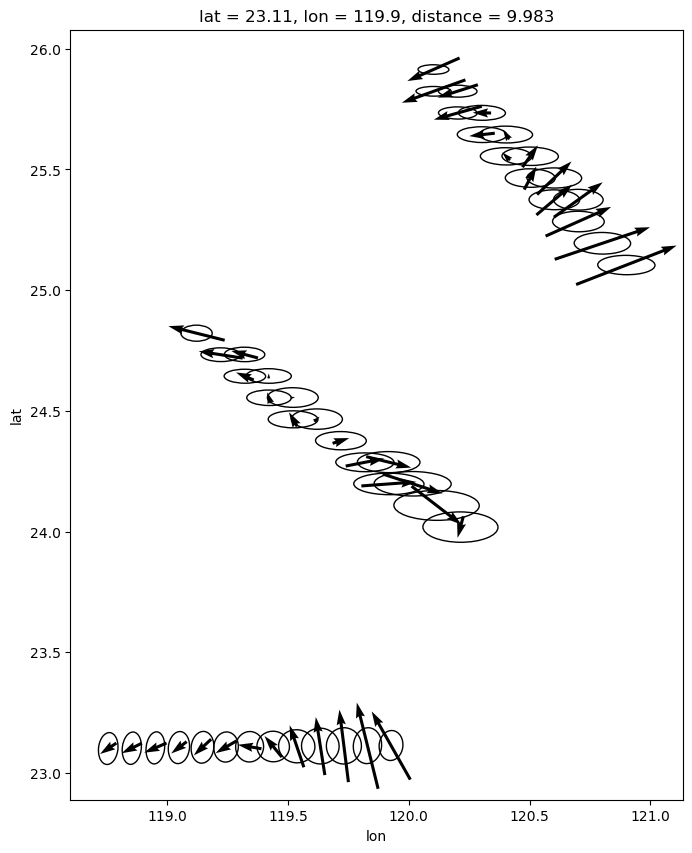

In [198]:
fig,ax= plt.subplots(1,1,figsize=(10,10))
for s in np.arange(2,len(north_mean.s)-1):
    north_mean.isel(s=s).plot.quiver(ax=ax,x='lon',y='lat',u='along_vel',v='cross_vel',scale=1,linewidth=0.5,width=0.005,add_guide=False)
    ell = mpl.patches.Ellipse(xy=[north_section.isel(s=s).lon,north_section.isel(s=s).lat],
                              width=north_u_std.isel(s=s), height=north_v_std.isel(s=s), 
                              angle = -np.deg2rad(calculate_initial_compass_bearing(
                                  (north_section.lon[0],north_section.lat[0]),(north_section.lon[-1],north_section.lat[-1]))),fc='none',ec='k')
    ax.add_patch(ell)
    
for s in np.arange(2,len(mid_mean.s)):
    mid_mean.isel(s=s).plot.quiver(ax=ax,x='lon',y='lat',u='along_vel',v='cross_vel',scale=1,linewidth=0.5,width=0.005,add_guide=False)
    ell = mpl.patches.Ellipse(xy=[mid_section.isel(s=s).lon,mid_section.isel(s=s).lat],
                              width=mid_u_std.isel(s=s), height=mid_v_std.isel(s=s), 
                              angle = -np.deg2rad(calculate_initial_compass_bearing(
                                  (mid_section.lon[0],mid_section.lat[0]),(mid_section.lon[-1],mid_section.lat[-1]))),fc='none',ec='k')
    ax.add_patch(ell)
    
for s in np.arange(1,len(south_mean.s)-1):
    south_mean.isel(s=s).plot.quiver(ax=ax,x='lon',y='lat',u='along_vel',v='cross_vel',scale=1,linewidth=0.5,width=0.005,add_guide=False)
    ell = mpl.patches.Ellipse(xy=[south_section.isel(s=s).lon,south_section.isel(s=s).lat],
                              width=south_u_std.isel(s=s), height=south_v_std.isel(s=s), 
                              angle = -np.deg2rad(calculate_initial_compass_bearing(
                                  (south_section.lon[0],south_section.lat[0]),(south_section.lon[-1],south_section.lat[-1]))),fc='none',ec='k')
    ax.add_patch(ell)
    ax.set_aspect('equal')
    ax.autoscale()
    
plt.savefig(figure_path + 'section_vel_vectors.png')

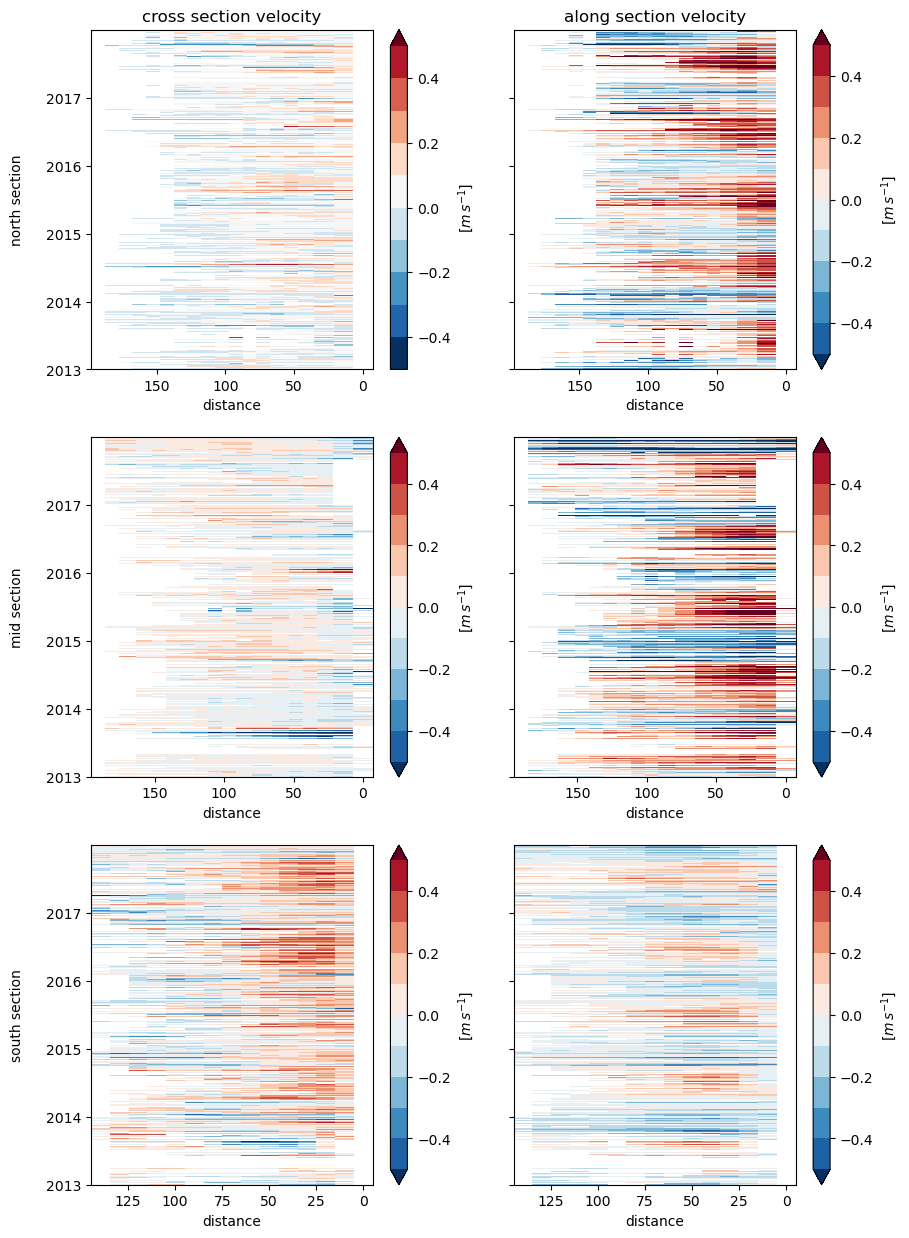

In [199]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,sharey=True,figsize=(10,15))

north_section.cross_vel.plot(ax=ax1,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})
north_section.along_vel.plot(ax=ax2,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})

mid_section.cross_vel.plot(ax=ax3,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})
mid_section.along_vel.plot(ax=ax4,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})

south_section.cross_vel.plot(ax=ax5,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})
south_section.along_vel.plot(ax=ax6,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})

ax1.set_ylabel('north section\n'),ax2.set_ylabel(''),ax3.set_ylabel('mid section\n'),ax4.set_ylabel(''),ax5.set_ylabel('south section\n'),ax6.set_ylabel('')
ax1.set_title('cross section velocity'),ax2.set_title('along section velocity');

plt.savefig(figure_path + 'sections_hovmoeller.png')

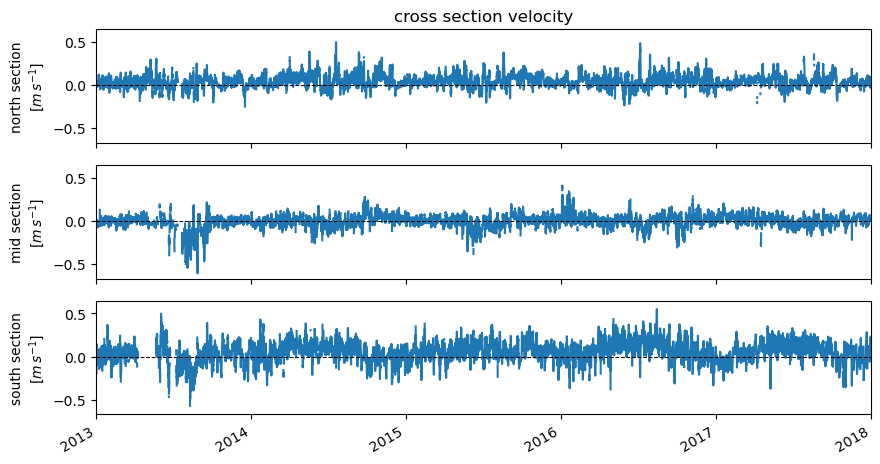

In [200]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,sharey=True,figsize=(10,5))
north_section.mean(dim='s').cross_vel.plot(ax=ax1,label='north')
mid_section.mean(dim='s').cross_vel.plot(ax=ax2,label='mid')
south_section.mean(dim='s').cross_vel.plot(ax=ax3,label='south')
ax1.set_xlabel(''),ax2.set_xlabel(''),ax3.set_xlabel('')
ax1.set_ylabel('north section\n' + '$[m\,s^{-1}]$'),ax2.set_ylabel('mid section\n' + '$[m\,s^{-1}]$'),ax3.set_ylabel('south section\n' + '$[m\,s^{-1}]$')
ax1.set_title('cross section velocity')

xmin,xmax = datetime(2013,1,1),datetime(2018,1,1)
ax1.hlines(0,xmin,xmax,color='k',linestyle='--',linewidth=0.75)
ax2.hlines(0,xmin,xmax,color='k',linestyle='--',linewidth=0.75)
ax3.hlines(0,xmin,xmax,color='k',linestyle='--',linewidth=0.75)
ax1.set_xlim([xmin,xmax])

plt.savefig(figure_path + 'sections_mean_timeseries_cross.png')

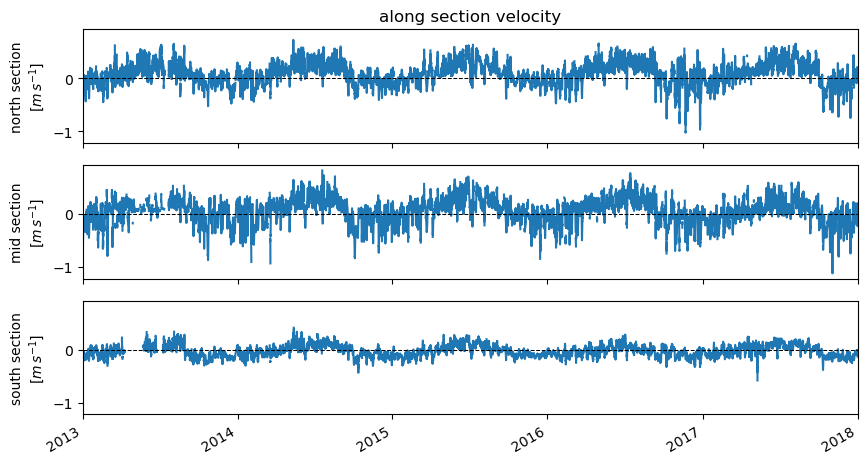

In [201]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,sharey=True,figsize=(10,5))
north_section.mean(dim='s').along_vel.plot(ax=ax1,label='north')
mid_section.mean(dim='s').along_vel.plot(ax=ax2,label='mid')
south_section.mean(dim='s').along_vel.plot(ax=ax3,label='south')
ax1.set_xlabel(''),ax2.set_xlabel(''),ax3.set_xlabel('')
ax1.set_ylabel('north section\n' + '$[m\,s^{-1}]$'),ax2.set_ylabel('mid section\n' + '$[m\,s^{-1}]$'),ax3.set_ylabel('south section\n' + '$[m\,s^{-1}]$')
ax1.set_title('along section velocity')

xmin,xmax = datetime(2013,1,1),datetime(2018,1,1)
ax1.hlines(0,xmin,xmax,color='k',linestyle='--',linewidth=0.75)
ax2.hlines(0,xmin,xmax,color='k',linestyle='--',linewidth=0.75)
ax3.hlines(0,xmin,xmax,color='k',linestyle='--',linewidth=0.75)
ax1.set_xlim([xmin,xmax])

plt.savefig(figure_path + 'sections_mean_timeseries_along.png')

In [34]:
velocity_masked = velocity.where(velocity.coverage > 0.5)

In [35]:
mean = velocity.where(mask == 1).mean(dim='time')
std = velocity.where(mask == 1).std(dim='time')

# velocity['coverage'] = velocity.coverage.where(velocity.coverage != 0)

C:\Users\2311043\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


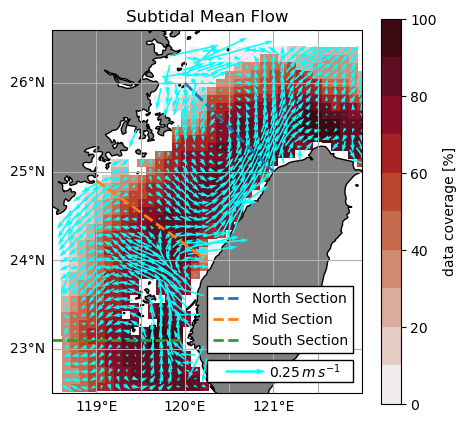

In [224]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

(velocity.coverage*100).where(mask == 1).plot(x='lon', y='lat', cmap=cmo.amp,
                                              levels=np.arange(0, 110, 10), zorder=-2,
                                              cbar_kwargs={'ticks': np.arange(0, 120, 20),
                                                           'label': 'data coverage [%]'})

# for x in range(49):
#     for y in range(60):
#         if ~np.isnan(std.isel(x=x, y=y).u_filtered):
#             ell = mpl.patches.Ellipse(xy=[std.isel(x=x, y=y).lon, std.isel(x=x, y=y).lat], 
#                                       width=std.isel(x=x, y=y).u_filtered/2,
#                                       height=std.isel(x=x, y=y).v_filtered/2,
#                                       angle=0, fc='none', ec='lightgrey',
#                                       transform=ccrs.PlateCarree())

#             ax.add_patch(ell)
#         else:
#             continue
            
# xr.plot.scatter(ax=ax,ds=velocity.isel(x=26,y=20),x='lon',y='lat',transform=ccrs.PlateCarree())
qv = mean.plot.quiver(ax=ax, x='lon', y='lat', u='u_filtered', v='v_filtered',
                       linewidth=0.5, width=0.005, scale=2, color='cyan',
                       add_guide=False, zorder=0)

# ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='grey', edgecolor='black')

gl = ax.gridlines(draw_labels=True, zorder=-1)
ax.set_aspect('equal')
ax.autoscale()
ax.set_extent([118.5, 122, 22.5, 26.6])
gl.right_labels = False
gl.top_labels = False

rect = patches.Rectangle((120.25,22.625), 1.65, 0.25, edgecolor='k', facecolor='white', transform=ccrs.PlateCarree(),zorder=-0.5)
ax.add_patch(rect)
qk = ax.quiverkey(qv, 0.685, 0.06, 0.25, r'$0.25\,m\,s^{-1}$', labelpos='E',
                      labelsep=0.05, color='cyan')

ax.set_title('Subtidal Mean Flow')

ax.plot([120, 121], [26, 25], linestyle='--', linewidth=2,
        transform=ccrs.PlateCarree(), label='North Section')
ax.plot([119, 120.25], [24.9, 24], linestyle='--', linewidth=2,
        transform=ccrs.PlateCarree(), label='Mid Section')
ax.plot([118.5, 120], [23.1, 23.1], linestyle='--', linewidth=2,
        transform=ccrs.PlateCarree(), label='South Section')
ax.legend(loc=(0.5, 0.11), edgecolor='k', framealpha=1).get_frame().set_boxstyle('Square', pad=0)

plt.savefig(figure_path + 'taiwanstrait_mean_coverage.png')

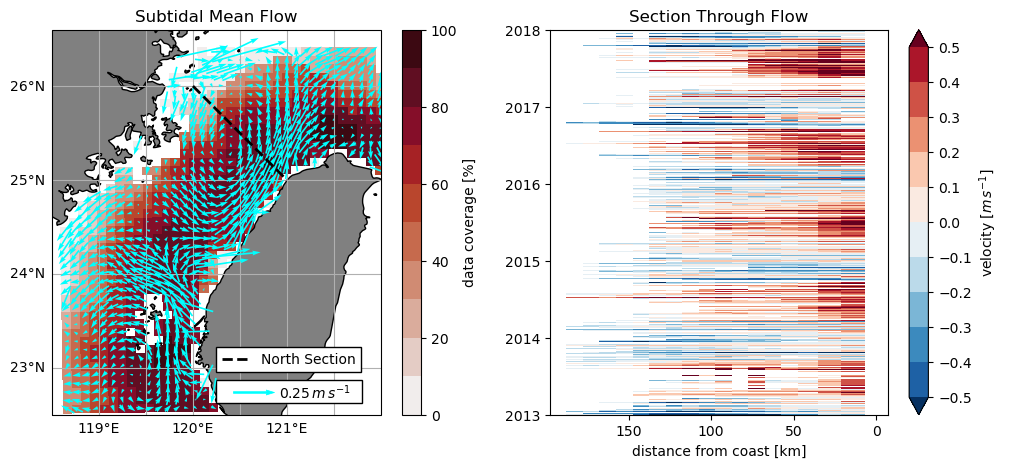

In [279]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(122)

(velocity.coverage*100).where(mask == 1).plot(ax=ax, x='lon', y='lat', cmap=cmo.amp,
                                              levels=np.arange(0, 110, 10), zorder=-2,
                                              cbar_kwargs={'ticks': np.arange(0, 120, 20),
                                                           'label': 'data coverage [%]'})

qv = mean.plot.quiver(ax=ax, x='lon', y='lat', u='u_filtered', v='v_filtered',
                      linewidth=0.5, width=0.005, scale=2, color='cyan',
                      add_guide=False, zorder=0)

ax.add_feature(cfeature.LAND, facecolor='grey', edgecolor='black')

gl = ax.gridlines(draw_labels=True, zorder=-1)
ax.set_aspect('equal')
ax.autoscale()
ax.set_extent([118.5, 122, 22.5, 26.6])
gl.right_labels = False
gl.top_labels = False

rect = patches.Rectangle((120.25, 22.625), 1.55, 0.25, edgecolor='k',
                         facecolor='white', transform=ccrs.PlateCarree(), zorder=-0.5)
ax.add_patch(rect)
qk = ax.quiverkey(qv, 0.675, 0.06, 0.25, r'$0.25\,m\,s^{-1}$', labelpos='E',
                  labelsep=0.05, color='cyan')

ax.set_title('Subtidal Mean Flow')

ax.plot([120, 121], [26, 25], linestyle='--', linewidth=2, color='k',
        transform=ccrs.PlateCarree(), label='North Section')
# ax.plot([119, 120.25], [24.9, 24], linestyle='--', linewidth=2,
#         transform=ccrs.PlateCarree(), label='Mid Section')
# ax.plot([118.5, 120], [23.1, 23.1], linestyle='--', linewidth=2,
#         transform=ccrs.PlateCarree(), label='South Section')
ax.legend(loc=(0.5, 0.11), edgecolor='k', framealpha=1).get_frame().set_boxstyle('Square', pad=0)

north_section.along_vel.plot(ax=ax2, x='distance', y='time',
                             levels=np.arange(-0.5, 0.6, 0.1), xincrease=False,
                             cbar_kwargs={'label': r'velocity $[m\,s^{-1}]$',
                                          'ticks': np.arange(-0.5, 0.6, 0.1)})
ax2.set_title('Section Through Flow')
ax2.set_ylabel('')
ax2.set_xlabel('distance from coast [km]')
ax2.set_ylim([datetime(2013, 1, 1), datetime(2018, 1, 1)])

plt.savefig(figure_path + 'taiwanstrait_mean_coverage_northsection.png')

# Wind

In [23]:
wind = xr.open_dataset(input_path + 'ERA5_10m_winds.nc')
wind = wind.rename({'longitude': 'lon', 'latitude': 'lat'})
# velocity = xr.open_dataset(input_path + 'velocity_raw_filtered_ERA5Grid.nc')

In [96]:
wind = (wind*~np.isnan(velocity.u_filtered))
wind = wind.where(wind.u10!=0)

In [14]:
wind['abs'] = np.sqrt(wind.u10**2 + wind.v10**2)

In [15]:
c_D = 0.0015
rho_air = 1.2
wind['taux'] = rho_air * c_D * wind.abs * wind.u10
wind['tauy'] = rho_air * c_D * wind.abs * wind.v10

In [99]:
wind_vel = xr.merge([wind,velocity])

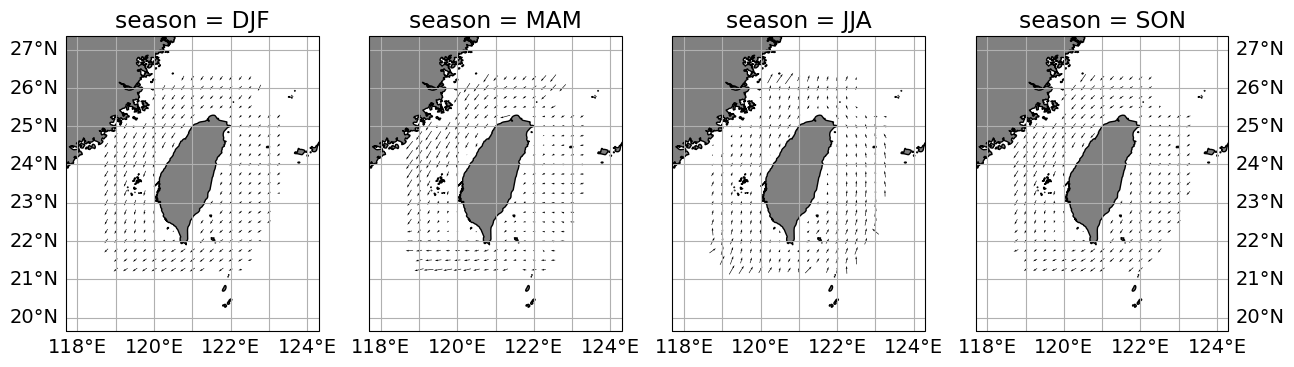

In [100]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})

season_mean = wind.groupby('time.season').mean()
season_mean.sel(season='DJF').plot.quiver('lon','lat','u10','v10',ax=ax1,add_guide=False)
season_mean.sel(season='MAM').plot.quiver('lon','lat','u10','v10',ax=ax2,add_guide=False)
season_mean.sel(season='JJA').plot.quiver('lon','lat','u10','v10',ax=ax3,add_guide=False)
season_mean.sel(season='SON').plot.quiver('lon','lat','u10','v10',ax=ax4,add_guide=False)

ax1.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False

ax2.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl2 = ax2.gridlines(draw_labels=True)
gl2.top_labels=False
gl2.right_labels=False
gl2.left_labels=False

ax3.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl3 = ax3.gridlines(draw_labels=True)
gl3.top_labels=False
gl3.right_labels=False
gl3.left_labels=False

ax4.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl4 = ax4.gridlines(draw_labels=True)
gl4.top_labels=False
gl4.left_labels=False

plt.savefig(figure_path + 'winds_seasonal.png')

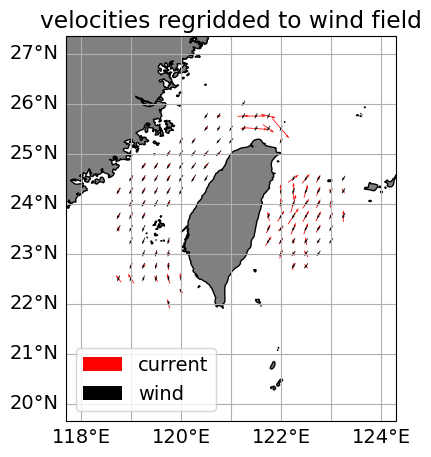

In [106]:
fig,(ax1) = plt.subplots(1,1,figsize=(5,5),subplot_kw={'projection':ccrs.PlateCarree()})
velocity.isel(time=200).plot.quiver(x='lon',y='lat',u='u_filtered',v='v_filtered',color='r',add_guide=False,label='current')
(wind*~np.isnan(velocity.u_filtered)).isel(time=200).plot.quiver(x='lon',y='lat',u='u10',v='v10',add_guide=False,label='wind')
ax1.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False
ax1.legend(loc='lower left')
ax1.set_title('velocities regridded to wind field')
plt.savefig(figure_path + 'velocity_wind_grid.png',dpi=300)

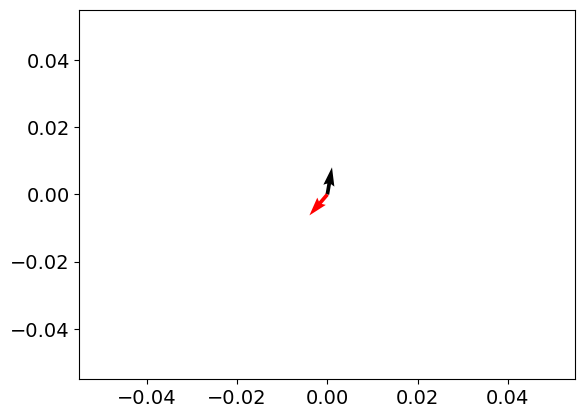

In [ ]:
# plt.quiver(0,0,velocity.u_filtered[1,12,20],velocity.v_filtered[1,12,20])
plt.quiver(0,0,velocity.u[-1,12,20],velocity.v[-1,12,20])

plt.quiver(0,0,wind.taux[-1,12,20],wind.tauy[-1,12,20],color='r')

In [91]:
# v1 = [velocity.u_filtered[200,12,20],velocity.v_filtered[200,12,20]]
v1 = [(u,v) for u,v in zip(velocity.u[:,12,20].data,velocity.v[:,12,20].data)]

v2 = [(u,v) for u,v in zip(wind.taux[:,12,20].data,wind.tauy[:,12,20].data)]

np.degrees(list(map(angle_between,v1,v2)))

array([         nan,  92.43199868,  96.51287454, ..., 149.83431261,
       147.81528909, 149.1096531 ])

In [ ]:
angles = angle_between_vectors_xarray(wind_vel,['u','v','taux','tauy'])

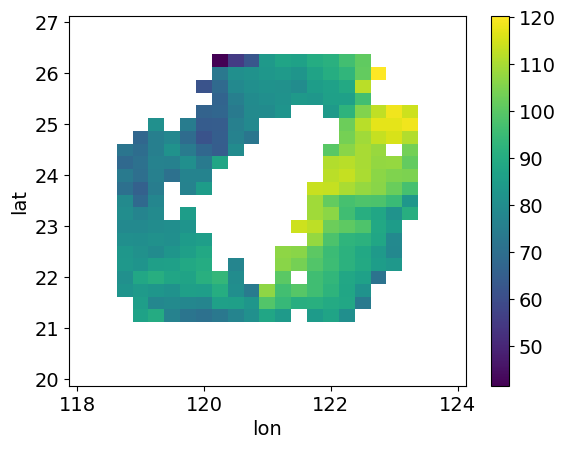

In [57]:
np.degrees(angles.mean(dim='time')).plot()

# EOF

In [4]:
velocity = xr.open_dataset(input_path + 'velocity_raw_filtered.nc')
velocity['u_demeaned'],velocity['u_mean'] = demean_xarray(velocity.u_filtered,dim='time')
velocity['v_demeaned'],velocity['v_mean'] = demean_xarray(velocity.v_filtered,dim='time')

In [6]:
coslat = np.cos(np.deg2rad(velocity.coords['lat'].values)).clip(0., 1.)
wgts = np.sqrt(coslat)
wgts = xr.DataArray(wgts, dims=['y', 'x'],
                    coords={'lat': (['y', 'x'], velocity.lat.data),
                            'lon': (['y', 'x'], velocity.lon.data)})

In [7]:
pca = xeofs.xarray.EOF(
    [velocity.u_demeaned.fillna(0)*mask, velocity.v_demeaned.fillna(0)*mask],
    dim='time',
    norm=False,
    weights=wgts
)
pca.solve()
eofs = pca.eofs()
pcs = pca.pcs()
expvar = pca.explained_variance_ratio()

In [8]:
eof = xr.Dataset(coords={'lat': (['y', 'x'], velocity.lat.values),
                         'lon': (['y', 'x'], velocity.lon.values),
                         'mode': ('mode', expvar.mode.values),
                         'time': ('time', pcs.time.values)},
                 data_vars={
    'pcs': (['time', 'mode'], pcs.data),
    'eofsu': (['y', 'x', 'mode'], eofs[0].data),
    'eofsv': (['y', 'x', 'mode'], eofs[1].data),
    'expvar': ('mode', expvar.data)
})

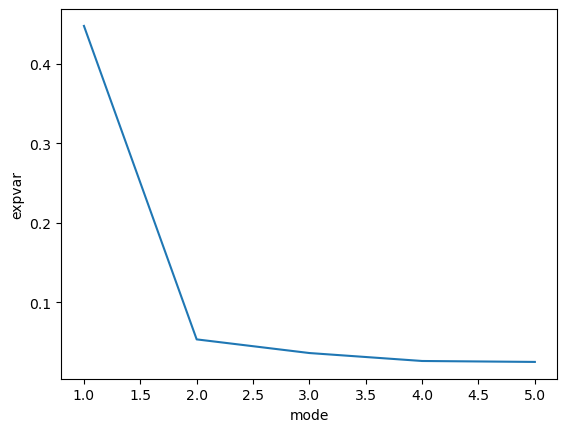

In [225]:
eof.expvar[:5].plot()
# plt.savefig(figure_path + 'eof_expvar.png')

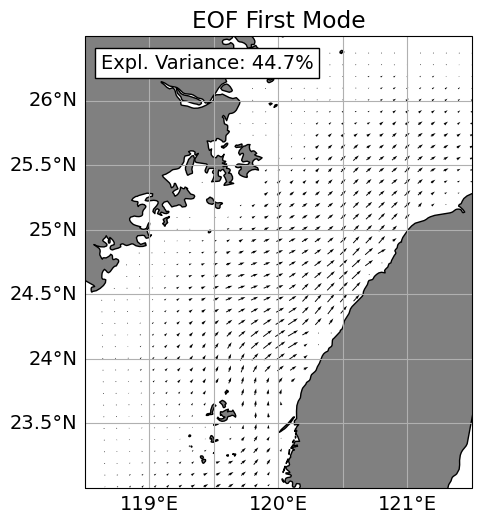

In [14]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(5, 8))

# gs = GridSpec(2, 1, width_ratios=[1], height_ratios=[3, 1])

ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree())
# ax2 = fig.add_subplot(gs[1])

eof.isel(mode=0).plot.quiver(ax=ax1, x='lon', y='lat',
                             u='eofsu', v='eofsv', add_guide=False)

ax1.set_extent([118.5, 121.5, 23, 26.5])
gl1 = ax1.gridlines(draw_labels=True)
gl1.right_labels = False
gl1.top_labels = False
ax1.add_feature(cfeature.LAND, facecolor='grey', edgecolor='black')
ax1.set_title('EOF First Mode')
ax1.text(118.625, 26.25, f'Expl. Variance: {eof.expvar[0]*100:.1f}%',
         bbox={'facecolor': 'white'})

# eof.pcs.isel(mode=0).plot(ax=ax2)

# ax2.set_title('Principle Component Time Series')
# ax2.set_xlabel('')
# ax2.set_ylabel('')
# ax2.set_yticks(np.arange(-0.02, 0.03, 0.01))
# ax2.set_ylim([-0.02, 0.02])
# ax2.hlines(0, datetime(2013, 1, 1), datetime(2018, 1, 1), color='k',
#            linestyle='--')
# ax2.set_xlim([datetime(2013, 1, 1), datetime(2018, 1, 1)])
plt.savefig(figure_path + 'eof_mode1_map.png',bbox_inches='tight')

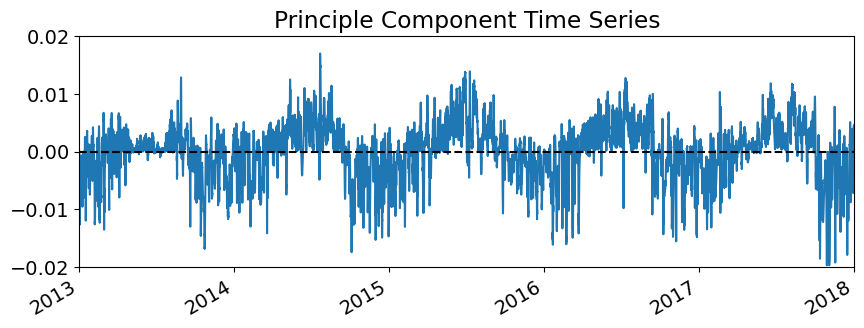

In [13]:
fig,ax2 = plt.subplots(1, 1, figsize=(10,3))
eof.pcs.isel(mode=0).plot(ax=ax2)

ax2.set_title('Principle Component Time Series')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_yticks(np.arange(-0.02, 0.03, 0.01))
ax2.set_ylim([-0.02, 0.02])
ax2.hlines(0, datetime(2013, 1, 1), datetime(2018, 1, 1), color='k',
           linestyle='--')
ax2.set_xlim([datetime(2013, 1, 1), datetime(2018, 1, 1)])
plt.savefig(figure_path + 'eof_mode1_pcs.png',bbox_inches='tight')

In [54]:
da = nufft(eof.pcs[:, 0])

In [56]:
da.shape

(43824, 5)

(1e-14, 1e-05)

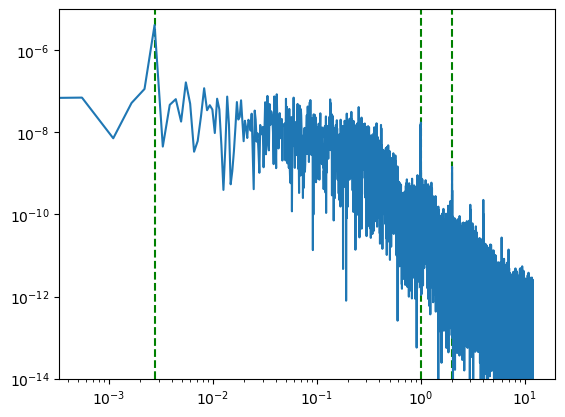

In [62]:
ymin, ymax = 1e-14, 1e-5
plt.vlines([1/365,1,2], ymin, ymax, color='g', linestyle='--')
plt.loglog(da[:,0]*24, da[:,2])
plt.ylim([ymin, ymax])

# SSH

In [4]:
sshfile = 'cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1679615605995.nc'
ssh = xr.open_dataset(input_path + sshfile)
ssh = ssh.rename({'latitude': 'lat', 'longitude': 'lon'})
velocity = xr.open_dataset(input_path + 'velocity_raw_filtered_CMEMSGrid.nc')
velocity = velocity.resample(time='1D').mean()

In [34]:
wind = wind.resample(time='1D').mean()

In [128]:
ssh = (ssh*~np.isnan(velocity.u_filtered))
ssh = ssh.where(ssh.ugos!=0)

In [129]:
ssh['abs'] = np.sqrt(ssh.ugos**2 + ssh.vgos**2)
velocity['abs'] = np.sqrt(velocity.u_filtered**2 + velocity.v_filtered**2)

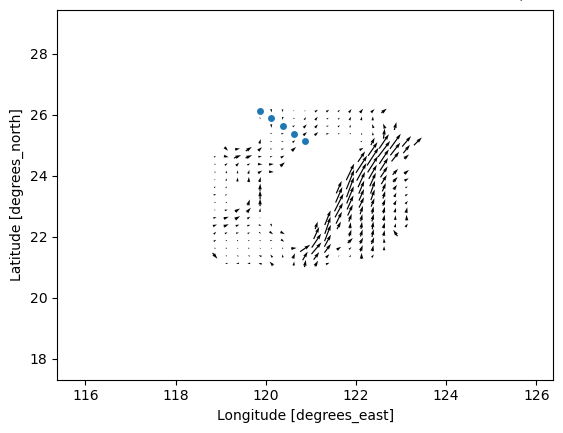

In [132]:
ssh.mean(dim='time').plot.quiver(x='lon',y='lat',u='ugos',v='vgos')
xr.plot.scatter(north_section_ssh,x='lon',y='lat')

In [131]:
north_section_ssh = extract_section(ssh,(26,120),(25,121))
mid_section_ssh = extract_section(ssh,(24.65,118.75),(24,120.25))
south_section_ssh = extract_section(ssh,(23.1,118.5),(23.1,120))

north_section_ssh = rotate_section(north_section_ssh,['ugos','vgos'])
mid_section_ssh = rotate_section(mid_section_ssh,['ugos','vgos'])
south_section_ssh = rotate_section(south_section_ssh,['ugos','vgos'])

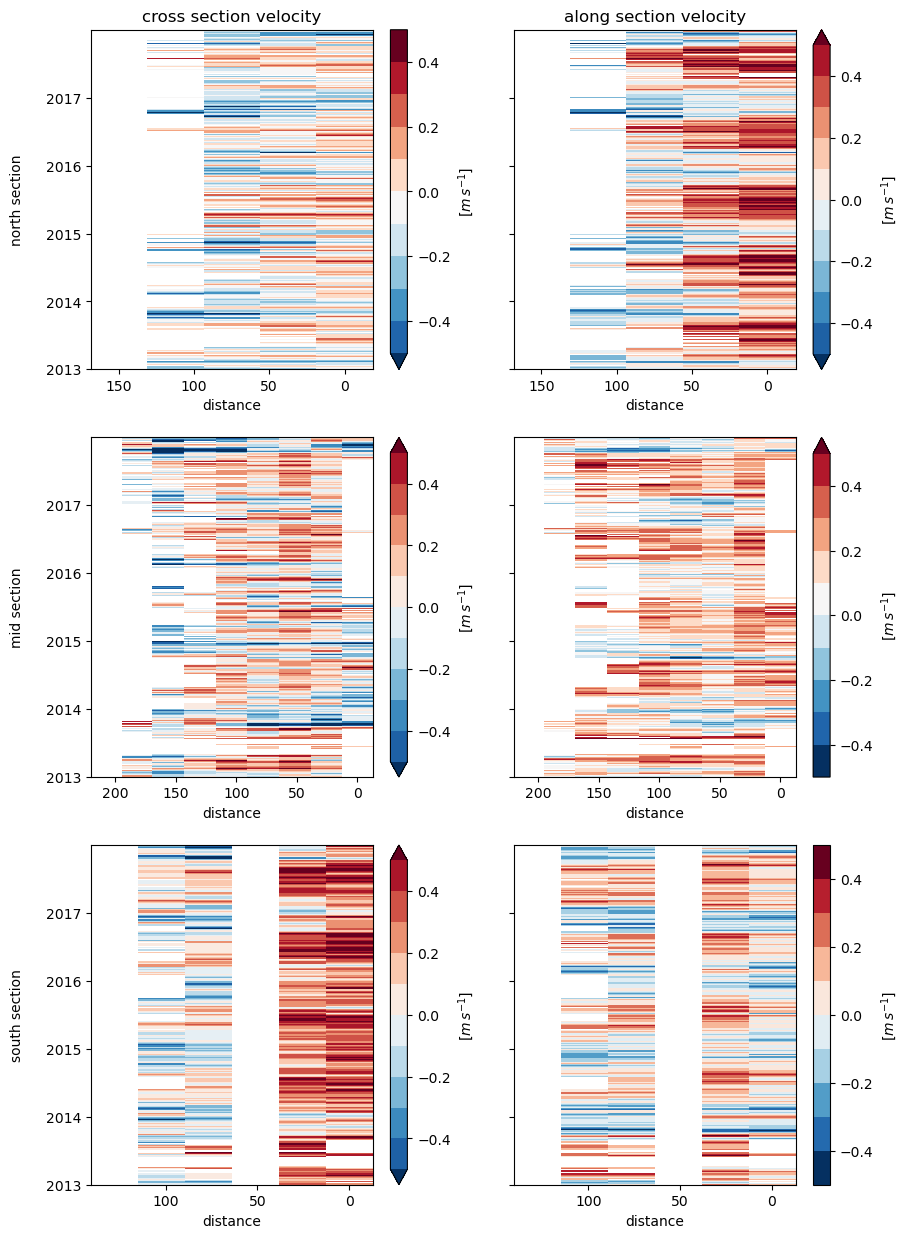

In [133]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,sharey=True,figsize=(10,15))

north_section_ssh.cross_vel.plot(ax=ax1, x='distance', y='time', levels=np.arange(-0.5, 0.6, 0.1), xincrease=False, cbar_kwargs={'label': r'$[m\,s^{-1}]$'})
north_section_ssh.along_vel.plot(ax=ax2,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})

mid_section_ssh.cross_vel.plot(ax=ax3,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})
mid_section_ssh.along_vel.plot(ax=ax4,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})

south_section_ssh.cross_vel.plot(ax=ax5,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})
south_section_ssh.along_vel.plot(ax=ax6,x='distance',y='time',levels=np.arange(-0.5,0.6,0.1),xincrease=False,cbar_kwargs={'label':r'$[m\,s^{-1}]$'})

ax1.set_ylabel('north section\n'),ax2.set_ylabel(''),ax3.set_ylabel('mid section\n'),ax4.set_ylabel(''),ax5.set_ylabel('south section\n'),ax6.set_ylabel('')
ax1.set_title('cross section velocity'),ax2.set_title('along section velocity');

# plt.savefig(figure_path + 'sections_hovmoeller.png')

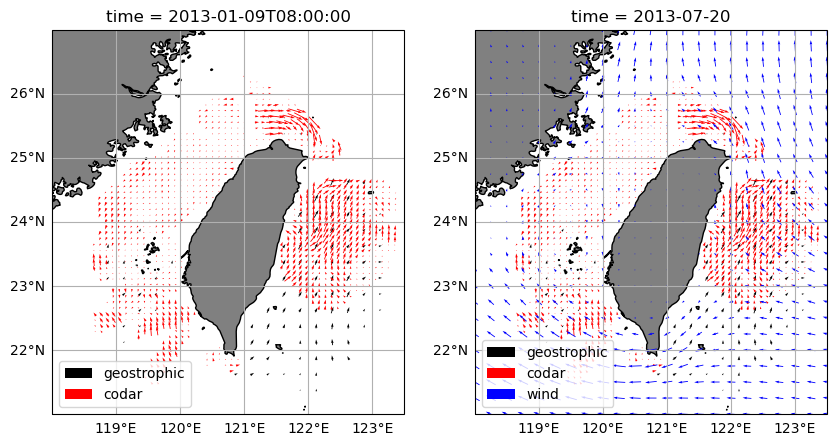

In [135]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5),subplot_kw={'projection':ccrs.PlateCarree()})
ssh.isel(time=200).plot.quiver(ax=ax1,x='lon',y='lat',u='ugos',v='vgos',add_guide=False,label='geostrophic')
velocity.isel(time=200).plot.quiver(ax=ax1,x='lon',y='lat',u='u_filtered',v='v_filtered',color='r',add_guide=False,label='codar')
# wind.isel(time=200).plot.quiver(ax=ax1,x='lon',y='lat',u='u10',v='v10',add_guide=False,label='wind',color='b')

ax1.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False
ax1.legend(loc='lower left')
# ax1.set_title('velocities regridded to wind field')
ax1.set_extent([118,123.5,21,27])

ssh.isel(time=200).plot.quiver(ax=ax2,x='lon',y='lat',u='ugos',v='vgos',add_guide=False,label='geostrophic')
velocity.isel(time=200).plot.quiver(ax=ax2,x='lon',y='lat',u='u_filtered',v='v_filtered',color='r',add_guide=False,label='codar')
wind.isel(time=200).plot.quiver(ax=ax2,x='lon',y='lat',u='u10',v='v10',add_guide=False,label='wind',color='b')

ax2.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl2 = ax2.gridlines(draw_labels=True)
gl2.top_labels=False
gl2.right_labels=False
ax2.legend(loc='lower left')
# ax2.set_title('velocities regridded to wind field')
ax2.set_extent([118,123.5,21,27])


# plt.savefig(figure_path + 'velocity_ssh_grid.png',dpi=300)

In [143]:
u_diff = ssh.ugos - velocity.u_filtered
v_diff = ssh.vgos - velocity.v_filtered 

In [144]:
velocity['u_diff_mean'] = u_diff.mean(dim='time')
velocity['v_diff_mean'] = v_diff.mean(dim='time')

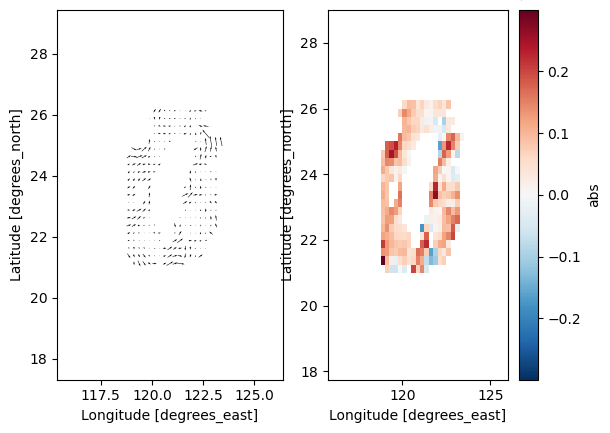

In [150]:
fig,(ax1,ax2) = plt.subplots(1,2)
velocity.plot.quiver(ax=ax1,x='lon',y='lat',u='u_diff_mean',v='v_diff_mean')
(ssh.abs - velocity.abs).mean(dim='time').plot(ax=ax2,x='lon',y='lat')

# Codar,Wind,Geostrophic Spectra

In [12]:
ssh = xr.open_dataset(input_path + 'cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1679615605995.nc')
ssh = ssh.rename({'latitude':'lat','longitude':'lon'})
velocity = xr.open_dataset(input_path + 'velocity_raw_filtered_CMEMSGrid.nc')
velocity = velocity.resample(time='1D').mean()
wind = xr.open_dataset(input_path + 'ERA5_10m_wind_CMEMSGrid.nc')
# wind = wind.rename({'longitude':'lon','latitude':'lat'})
wind = wind.resample(time='1D').mean()

In [24]:
velocity['u_demeaned'],velocity['u_mean'] = demean_xarray(velocity.u,dim='time')
velocity['v_demeaned'],velocity['v_mean'] = demean_xarray(velocity.v,dim='time')

velocity['u_detrended'],velocity['u_trend'] = detrend_xarray(velocity['u_demeaned'])
velocity['v_detrended'],velocity['v_trend'] = detrend_xarray(velocity['v_demeaned'])

In [25]:
ssh['u_demeaned'],ssh['u_mean'] = demean_xarray(ssh.ugos,dim='time')
ssh['v_demeaned'],ssh['v_mean'] = demean_xarray(ssh.vgos,dim='time')

ssh['u_detrended'],ssh['u_trend'] = detrend_xarray(ssh['u_demeaned'])
ssh['v_detrended'],ssh['v_trend'] = detrend_xarray(ssh['v_demeaned'])

In [26]:
wind['u_demeaned'],wind['u_mean'] = demean_xarray(wind.u10,dim='time')
wind['v_demeaned'],wind['v_mean'] = demean_xarray(wind.v10,dim='time')

wind['u_detrended'],wind['u_trend'] = detrend_xarray(wind['u_demeaned'])
wind['v_detrended'],wind['v_trend'] = detrend_xarray(wind['v_demeaned'])

In [27]:
freq_vel,f_k_vel,ps_vel,psd_vel,t_vel = nufft(velocity.sel(lat=lat,lon=lon).u_detrended.data + 1j*velocity.sel(lat=lat,lon=lon).v_detrended.data,xarray_apply=False)
freq_ssh,f_k_ssh,ps_ssh,psd_ssh,t_ssh = nufft(ssh.sel(lat=lat,lon=lon).u_detrended.data + 1j*ssh.sel(lat=lat,lon=lon).v_detrended.data,xarray_apply=False)
freq_wind,f_k_wind,ps_wind,psd_wind,t_wind = nufft(wind.sel(lat=lat,lon=lon).u_detrended.data + 1j*wind.sel(lat=lat,lon=lon).v_detrended.data,xarray_apply=False)

In [59]:
%run Code_functions.ipynb

spectral_vel = spectral_analysis(velocity.u_detrended + 1j*velocity.v_detrended)
spectral_ssh = spectral_analysis(ssh.u_detrended + 1j*ssh.v_detrended)
spectral_wind = spectral_analysis(wind.u_detrended + 1j*wind.v_detrended)

In [108]:
spectral_vel = spectral_vel.where(spectral_vel.ps!=0)
spectral_ssh = spectral_ssh.where(spectral_ssh.ps!=0)
spectral_wind = spectral_wind.where(spectral_wind.ps!=0)

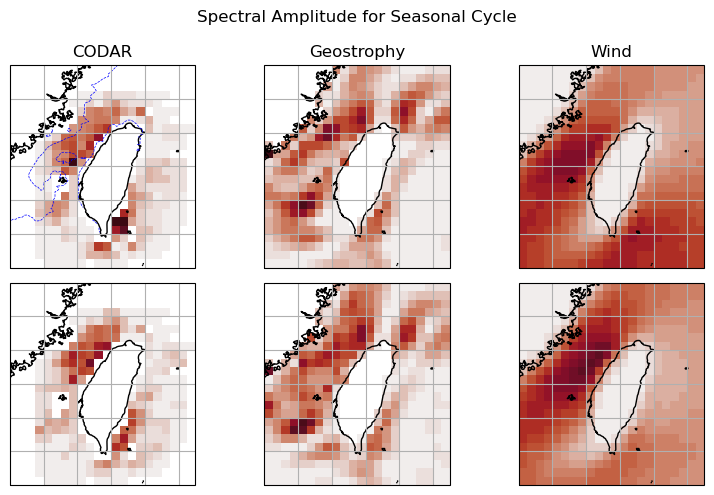

In [141]:
frequency = 1/365
levels = np.arange(0,0.021,0.001)

fig,axs = plt.subplots(2,3,sharex=True,sharey=True,figsize=(8,5),subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.ravel()

(abs(spectral_vel.ps.sel(freq=frequency,method='nearest'))).plot(ax=axs[0],x='lon',y='lat',cmap=cmo.amp,levels=levels,add_colorbar=False)
(abs(spectral_vel.ps.sel(freq=-frequency,method='nearest'))).plot(ax=axs[3],x='lon',y='lat',cmap=cmo.amp,levels=levels,add_colorbar=False)
(abs(spectral_ssh.ps.sel(freq=frequency,method='nearest'))).plot(ax=axs[1],x='lon',y='lat',cmap=cmo.amp,levels=levels,add_colorbar=False)
(abs(spectral_ssh.ps.sel(freq=-frequency,method='nearest'))).plot(ax=axs[4],x='lon',y='lat',cmap=cmo.amp,levels=levels,add_colorbar=False)
(abs(spectral_wind.ps.sel(freq=frequency,method='nearest'))/1000).plot(ax=axs[2],x='lon',y='lat',cmap=cmo.amp,levels=levels,add_colorbar=False)
(abs(spectral_wind.ps.sel(freq=-frequency,method='nearest'))/1000).plot(ax=axs[5],x='lon',y='lat',cmap=cmo.amp,levels=levels,add_colorbar=False)

bathy.ROSE.plot.contour(ax=axs[0],x='lon',y='lat',levels=[-50],colors='b',linewidths=0.5)

for ax in axs:
    ax.set_title(''),ax.set_xlabel(''),ax.set_ylabel('')
    ax.coastlines()
    ax.gridlines()
    ax.set_extent([118,123.5,21,27])

axs[0].set_title('CODAR')
axs[1].set_title('Geostrophy')
axs[2].set_title('Wind')
axs[0].set_ylabel('u-component')
axs[3].set_ylabel('v-component')

fig.suptitle('Spectral Amplitude for Seasonal Cycle')
fig.tight_layout()

Text(0.5, 0, 'cpy')

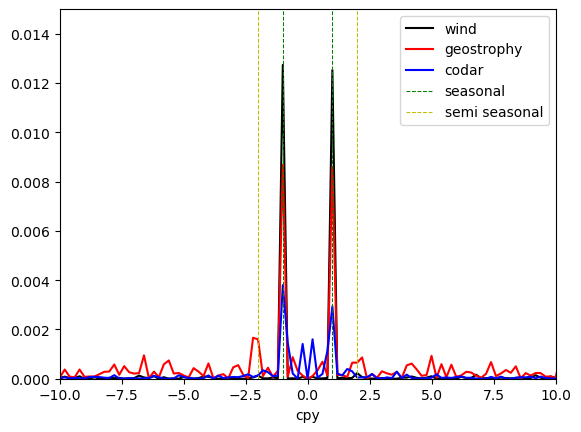

In [28]:
fig,ax1 = plt.subplots(1,1)
# ax2=ax1.twinx()
ax1.plot(freq_wind*365,ps_wind/1000,color='k',label='wind')
ax1.plot(freq_ssh*365,ps_ssh,color='r',label='geostrophy')
ax1.plot(freq_vel*365,ps_vel,color='b',label='codar')


plt.xlim([-10,10])
ax1.vlines([-1,1],0,0.015,color='g',linestyle='--',linewidth=0.75,label='seasonal')
ax1.vlines([-2,2],0,0.015,color='y',linestyle='--',linewidth=0.75,label='semi seasonal')

ax1.legend(loc='upper right')
# ax2.legend(loc='center right')
ax1.set_ylim([0,0.015])
# ax2.set_ylim([0,15])
ax1.set_xlabel('cpy')#,ax1.set_ylabel('ocean'),ax2.set_ylabel('atmosphere')

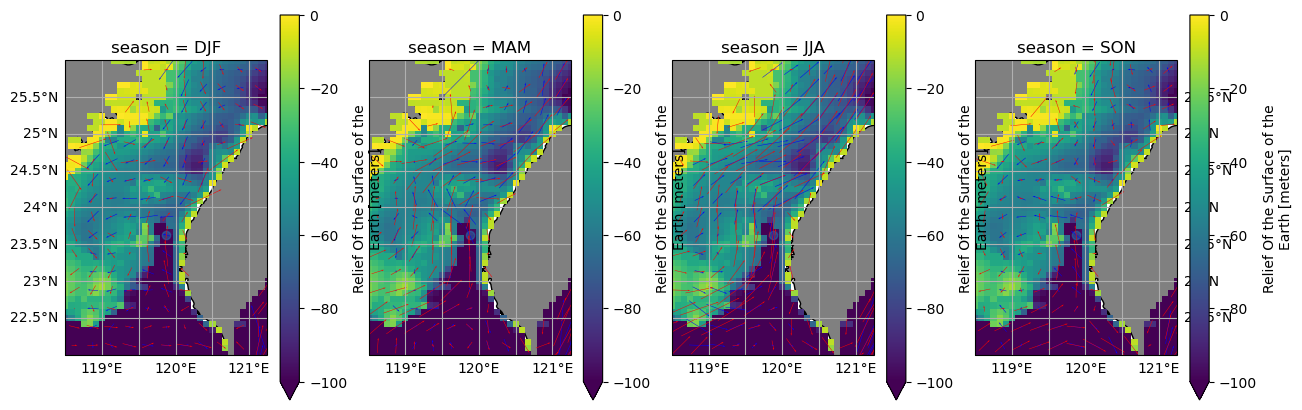

In [29]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,5),subplot_kw={'projection':ccrs.PlateCarree()})

bathy.sel(lat=slice(22,27),lon=slice(118,124)).ROSE.plot(ax=ax1,vmin=-100)
bathy.sel(lat=slice(22,27),lon=slice(118,124)).ROSE.plot(ax=ax2,vmin=-100)
bathy.sel(lat=slice(22,27),lon=slice(118,124)).ROSE.plot(ax=ax3,vmin=-100)
bathy.sel(lat=slice(22,27),lon=slice(118,124)).ROSE.plot(ax=ax4,vmin=-100)

ax1.scatter(lon,lat,alpha=0.5)
ax2.scatter(lon,lat,alpha=0.5)
ax3.scatter(lon,lat,alpha=0.5)
ax4.scatter(lon,lat,alpha=0.5)

season_mean = velocity.groupby('time.season').mean()
season_mean.sel(season='DJF').plot.quiver('lon','lat','u','v',ax=ax1,add_guide=False,color='b',scale=2)
season_mean.sel(season='MAM').plot.quiver('lon','lat','u','v',ax=ax2,add_guide=False,color='b',scale=2)
season_mean.sel(season='JJA').plot.quiver('lon','lat','u','v',ax=ax3,add_guide=False,color='b',scale=2)
season_mean.sel(season='SON').plot.quiver('lon','lat','u','v',ax=ax4,add_guide=False,color='b',scale=2)

season_mean = ssh.groupby('time.season').mean()
season_mean.sel(season='DJF').plot.quiver('lon','lat','ugos','vgos',ax=ax1,add_guide=False,color='r',scale=2)
season_mean.sel(season='MAM').plot.quiver('lon','lat','ugos','vgos',ax=ax2,add_guide=False,color='r',scale=2)
season_mean.sel(season='JJA').plot.quiver('lon','lat','ugos','vgos',ax=ax3,add_guide=False,color='r',scale=2)
season_mean.sel(season='SON').plot.quiver('lon','lat','ugos','vgos',ax=ax4,add_guide=False,color='r',scale=2)

# season_mean = wind.groupby('time.season').mean()
# season_mean.sel(season='DJF').plot.quiver('lon','lat','u10','v10',ax=ax1,add_guide=False,color='k',scale=20)
# season_mean.sel(season='MAM').plot.quiver('lon','lat','u10','v10',ax=ax2,add_guide=False,color='k',scale=20)
# season_mean.sel(season='JJA').plot.quiver('lon','lat','u10','v10',ax=ax3,add_guide=False,color='k',scale=20)
# season_mean.sel(season='SON').plot.quiver('lon','lat','u10','v10',ax=ax4,add_guide=False,color='k',scale=20)

ax1.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl1 = ax1.gridlines(draw_labels=True)
gl1.top_labels=False
gl1.right_labels=False

ax2.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl2 = ax2.gridlines(draw_labels=True)
gl2.top_labels=False
gl2.right_labels=False
gl2.left_labels=False

ax3.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl3 = ax3.gridlines(draw_labels=True)
gl3.top_labels=False
gl3.right_labels=False
gl3.left_labels=False

ax4.add_feature(cfeature.LAND, facecolor='grey',edgecolor='black')
gl4 = ax4.gridlines(draw_labels=True)
gl4.top_labels=False
gl4.left_labels=False

ax1.set_extent([118.5,121.25,22,26])
ax2.set_extent([118.5,121.25,22,26])
ax3.set_extent([118.5,121.25,22,26])
ax4.set_extent([118.5,121.25,22,26])

# plt.savefig(figure_path + 'seasonal_means.png')

# Codar, Wind, Geostrophic Differences

In [88]:
ssh = xr.open_dataset(input_path + 'cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1679615605995.nc')
ssh = ssh.rename({'latitude': 'lat', 'longitude': 'lon'})
velocity = xr.open_dataset(input_path + 'velocity_raw_filtered_CMEMSGrid.nc')
velocity = velocity.resample(time='1D').mean()
wind = xr.open_dataset(input_path + 'ERA5_10m_wind_CMEMSGrid.nc')
wind = wind.resample(time='1D').mean()

In [89]:
wind['abs'] = np.sqrt(wind.u10**2 + wind.v10**2)

c_D = 0.0015
rho_air = 1.2
wind['taux'] = rho_air * c_D * wind.abs * wind.u10
wind['tauy'] = rho_air * c_D * wind.abs * wind.v10

In [90]:
velocity['u_ageo'] = velocity.u_filtered - ssh.ugos
velocity['v_ageo'] = velocity.v_filtered - ssh.vgos

In [94]:
A_z = 0.01
rho = 1023
f = 2*7.29e-5*np.sin(np.deg2rad(24))
velocity['u_ekman'] = wind.taux / (rho*np.sqrt(A_z*f))
velocity['v_ekman'] = wind.tauy / (rho*np.sqrt(A_z*f))

In [95]:
velocity['u_residual'] = velocity.u_filtered - ssh.ugos - velocity.u_ekman
velocity['v_residual'] = velocity.v_filtered - ssh.vgos - velocity.v_ekman

In [63]:
mean = velocity.mean(dim='time')

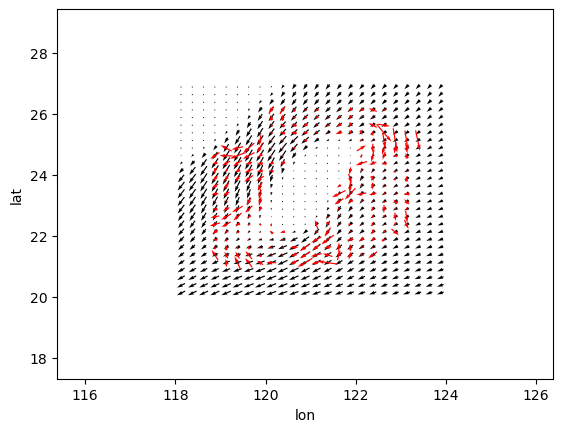

In [65]:
# ssh.mean(dim='time').plot.quiver(x='lon', y='lat', u='ugos', v='vgos', color='r')
mean.plot.quiver(x='lon', y='lat', u='u_ekman', v='v_ekman')
mean.plot.quiver(x='lon', y='lat', u='u_ageo', v='v_ageo', color='r')

# wind.mean(dim='time').plot.quiver(x='lon', y='lat', u='taux', v='tauy', color='b')

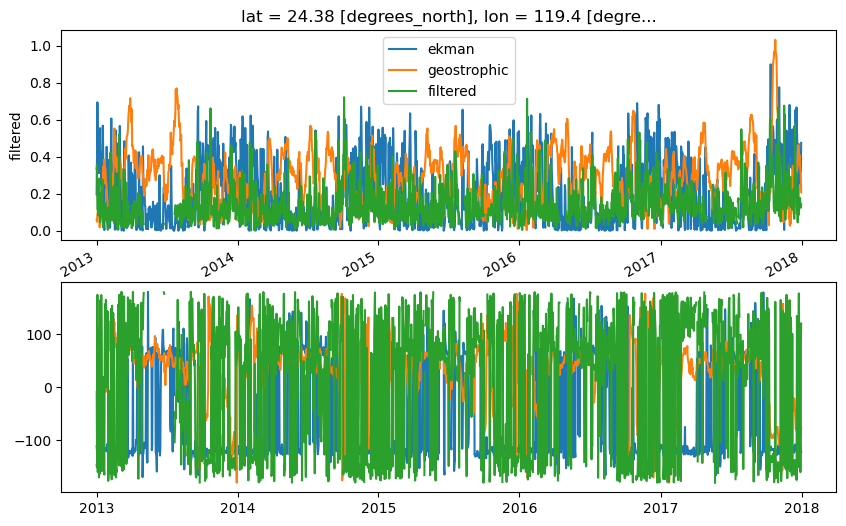

In [96]:
lat = 24.375
lon = 119.375
velocity['filtered'] = velocity.u_filtered + 1j*velocity.v_filtered
velocity['ekman'] = velocity.u_ekman + 1j*velocity.v_ekman
velocity['geostrophic'] = ssh.ugos + 1j* ssh.vgos

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
abs(velocity.sel(lat=lat, lon=lon).ekman).plot(ax=ax1, label='ekman')
abs(velocity.sel(lat=lat, lon=lon).geostrophic).plot(ax=ax1, label='geostrophic')
abs(velocity.sel(lat=lat, lon=lon).filtered).plot(ax=ax1, label='filtered')
# velocity.sel(lat=lat, lon=lon).u_ekman.plot(label='ekman')
ax1.legend()

ax2.plot(velocity.time, np.angle(velocity.sel(lat=lat, lon=lon).ekman, deg=True), label='ekman')
ax2.plot(velocity.time, np.angle(velocity.sel(lat=lat, lon=lon).geostrophic, deg=True), label='geostrophic')
ax2.plot(velocity.time, np.angle(velocity.sel(lat=lat, lon=lon).filtered, deg=True), label='filtered')

# vector correlation

In [15]:
velocity = xr.open_dataset(input_path + 'velocity_raw_filtered_CMEMSGrid.nc')
velocity = velocity.sel(lat=slice(20.125, 26.875), lon=slice(118.125, 123.875))
velocity_1D = velocity.resample(time='1D').mean()
wind = xr.open_dataset(input_path + 'ERA5_10m_wind_CMEMSGrid.nc')
wind_1D = wind.resample(time='1D').mean()
ssh = xr.open_dataset(input_path + 'cmems_obs-sl_glo_phy-ssh_my_allsat-' +
                      'l4-duacs-0.25deg_P1D_1679615605995.nc')
ssh = ssh.rename({'latitude': 'lat', 'longitude': 'lon'})
ssh = ssh.sel(lat=slice(20.125, 26.875), lon=slice(118.125, 123.875))

In [16]:
wind['abs'] = np.sqrt(wind.u10**2 + wind.v10**2)

c_D = 0.0015
rho_air = 1.2
wind['taux'] = rho_air * c_D * wind.abs * wind.u10
wind['tauy'] = rho_air * c_D * wind.abs * wind.v10

In [17]:
nan_mask = ~np.isnan(velocity.u)
data_coverage = np.sum(nan_mask, axis=0)/len(velocity.time)
velocity['coverage'] = data_coverage
velocity['coverage'] = velocity.coverage.where(velocity.coverage != 0)

In [21]:
corr_vel_wind = xarray_vector_correlation(velocity,wind,['u','v','taux','tauy'],lag=[0,'h'])

for lag in np.arange(1,28):
    corr_vel_wind = xr.concat([corr_vel_wind,xarray_vector_correlation(velocity,wind,['u','v','taux','tauy'],lag=[lag,'h'])],dim='lag')
    
corr_vel_wind = corr_vel_wind.assign_coords({'lag':np.arange(0,28)})    

corr_vel_wind['lag_rmax'] = corr_vel_wind.isel(lag=xr.DataArray(corr_vel_wind.r.data.argmax(axis=0),dims=['lat','lon'])).lag
corr_vel_wind['lag_vamax'] = corr_vel_wind.isel(lag=xr.DataArray(corr_vel_wind.va.data.argmax(axis=0),dims=['lat','lon'])).lag

corr_vel_wind.to_netcdf(input_path + 'corr_vel_wind_lag.nc')

/tmp/ipykernel_30237/2066736280.py:41: RuntimeWarning: invalid value encountered in cdouble_scalars
  rho = np.mean(np.conjugate(w1)*w2)/np.sqrt(np.mean(np.conjugate(w1)*w1))/\


In [22]:
corr_vel_ssh = xarray_vector_correlation(
    velocity_1D, ssh, ['u', 'v', 'ugos', 'vgos'], lag=[0, 'D'])

for lag in np.arange(1,8):
    corr_vel_ssh = xr.concat([corr_vel_ssh,xarray_vector_correlation(
        velocity_1D, ssh, ['u', 'v', 'ugos', 'vgos'],
        lag=[lag, 'D']
        )], dim='lag')
    
corr_vel_ssh = corr_vel_ssh.assign_coords({'lag':np.arange(0,8)})    

corr_vel_ssh['lag_rmax'] = corr_vel_ssh.isel(lag=xr.DataArray(corr_vel_ssh.r.data.argmax(axis=0),dims=['lat','lon'])).lag
corr_vel_ssh['lag_vamax'] = corr_vel_ssh.isel(lag=xr.DataArray(corr_vel_ssh.va.data.argmax(axis=0),dims=['lat','lon'])).lag

corr_vel_ssh.to_netcdf(input_path + 'corr_vel_ssh_lag.nc')

/tmp/ipykernel_30237/2066736280.py:41: RuntimeWarning: invalid value encountered in cdouble_scalars
  rho = np.mean(np.conjugate(w1)*w2)/np.sqrt(np.mean(np.conjugate(w1)*w1))/\


In [23]:
corr_vel_ssh = xr.open_dataset(input_path + 'corr_vel_ssh_lag.nc')
corr_vel_ssh_filtered = xr.open_dataset(input_path + 'corr_vel_ssh_lag_filtered.nc')
corr_vel_wind = xr.open_dataset(input_path + 'corr_vel_wind_lag.nc')
corr_vel_wind_filtered = xr.open_dataset(input_path + 'corr_vel_wind_lag_filtered.nc')

/tmp/ipykernel_30237/3166700320.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


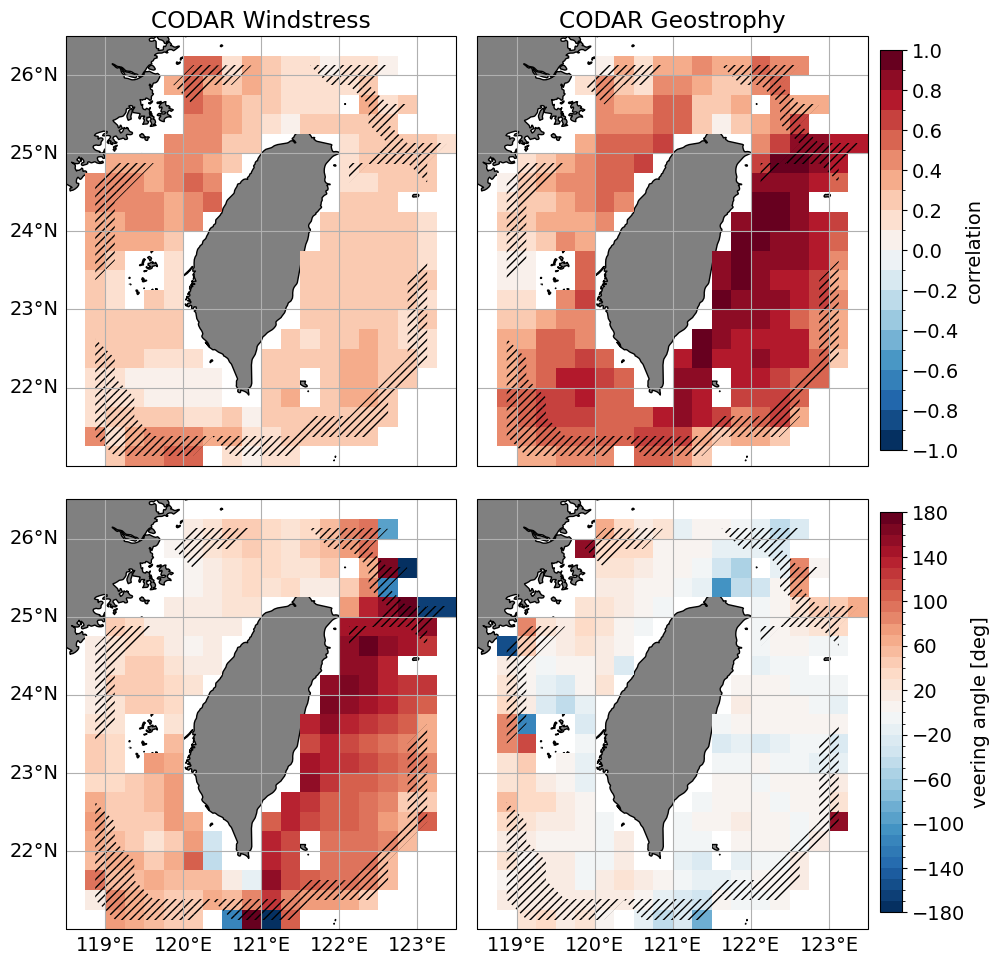

In [39]:
levels_corr = np.arange(-1, 1.1, 0.1)
levels_veer = np.arange(-180, 190, 10)
coverage_50 = velocity.coverage.where(velocity.coverage < 0.5)
coverage_50 = coverage_50.where(coverage_50 != 0)
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(9, 10),
                                 subplot_kw={'projection': ccrs.PlateCarree()})

plot1 = corr_vel_wind.sel(lag=0).r.plot(ax=ax1, levels=levels_corr, add_colorbar=False)
corr_vel_ssh.sel(lag=0).r.plot(ax=ax2, levels=levels_corr, add_colorbar=False)
plot2 = corr_vel_wind.sel(lag=0).va.plot(ax=ax3,levels=levels_veer, add_colorbar=False)
corr_vel_ssh.sel(lag=0).va.plot(ax=ax4,levels=levels_veer, add_colorbar=False)




ax1.add_feature(cfeature.LAND, facecolor='grey', edgecolor='black')
ax2.add_feature(cfeature.LAND, facecolor='grey', edgecolor='black')
ax3.add_feature(cfeature.LAND, facecolor='grey', edgecolor='black')
ax4.add_feature(cfeature.LAND, facecolor='grey', edgecolor='black')

coverage_50.plot.contourf(x='lon',y='lat',ax=ax1,alpha=0,hatches=['////'],add_colorbar=False,transform=ccrs.PlateCarree())
coverage_50.plot.contourf(x='lon',y='lat',ax=ax2,alpha=0,hatches=['////'],add_colorbar=False,transform=ccrs.PlateCarree())
coverage_50.plot.contourf(x='lon',y='lat',ax=ax3,alpha=0,hatches=['////'],add_colorbar=False,transform=ccrs.PlateCarree())
coverage_50.plot.contourf(x='lon',y='lat',ax=ax4,alpha=0,hatches=['////'],add_colorbar=False,transform=ccrs.PlateCarree())

ax1.set_title('CODAR Windstress')
ax2.set_title('CODAR Geostrophy')
# ax3.set_title('CODAR Windstress')
# ax4.set_title('CODAR Geostrophy')

# ax1.set_ylabel('Cross-Correlation')
# ax3.set_ylabel('Veering Angle')


gl1 = ax1.gridlines(draw_labels=True)
gl2 = ax2.gridlines()
gl3 = ax3.gridlines(draw_labels=True)
gl4 = ax4.gridlines(draw_labels=True)

gl1.top_labels = False
gl1.right_labels = False
gl1.bottom_labels = False

gl3.top_labels = False
gl3.right_labels = False

gl4.top_labels = False
gl4.left_labels = False
gl4.right_labels=False

ax1.set_extent([118.5, 123.5, 21, 26.5])
ax2.set_extent([118.5, 123.5, 21, 26.5])
ax3.set_extent([118.5, 123.5, 21, 26.5])
ax4.set_extent([118.5, 123.5, 21, 26.5])

cax1 = fig.add_axes([0.99, 0.5325, 0.025, 0.4])
cbar1 = fig.colorbar(plot1, orientation='vertical', cax=cax1)
cbar1.set_label(r'correlation')
cbar1.set_ticks(np.arange(-1, 1.2, 0.2))

cax2 = fig.add_axes([0.99, 0.07, 0.025, 0.4])
cbar2 = fig.colorbar(plot2, orientation='vertical', cax=cax2)
cbar2.set_label(r'veering angle [deg]')
cbar2.set_ticks(np.arange(-180,220,40))
fig.tight_layout()
plt.savefig(figure_path + 'vector_correlations_va_raw.png', bbox_inches='tight')

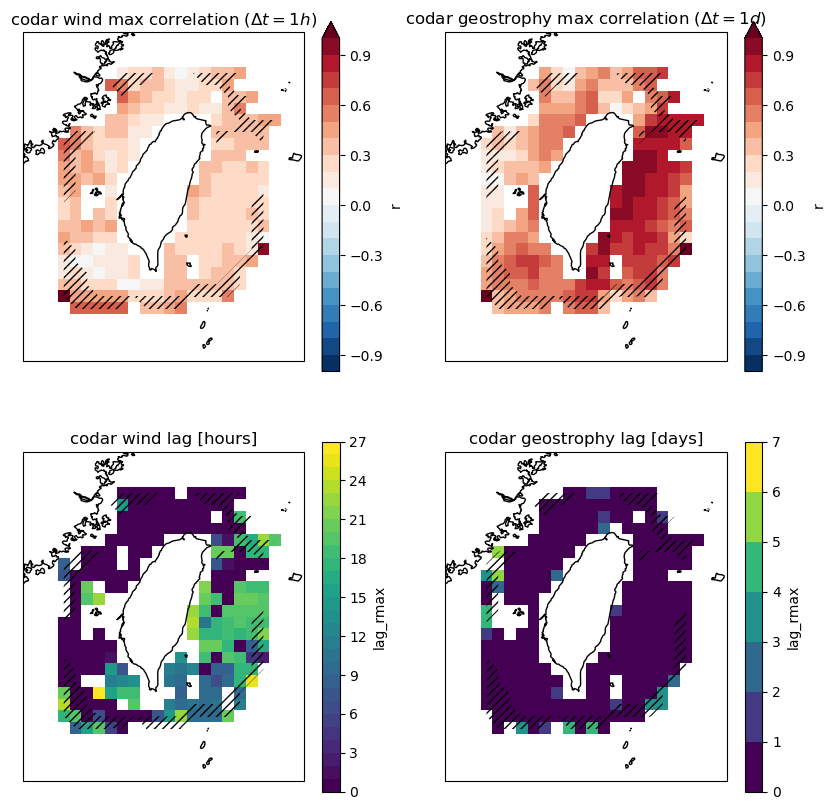

In [130]:
levels_corr = np.arange(-1,1.1,0.1)
levels_lag_wind = np.arange(0,28)
levels_lag_ssh = np.arange(0,8)

coverage_50 = velocity.coverage.where(velocity.coverage<0.5)

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex=True,sharey=True,figsize=(10,10),subplot_kw={'projection':ccrs.PlateCarree()})

corr_vel_wind.r.max(dim='lag').plot(ax=ax1,levels=levels_corr)
corr_vel_ssh.r.max(dim='lag').plot(ax=ax2,levels=levels_corr)
corr_vel_wind.lag_rmax.where(~np.isnan(corr_vel_wind.r.max(dim='lag'))).plot(ax=ax3,levels=levels_lag_wind)
corr_vel_ssh.lag_rmax.where(~np.isnan(corr_vel_ssh.r.max(dim='lag'))).plot(ax=ax4,levels=levels_lag_ssh)

coverage_50.plot.contourf(ax=ax1,alpha=0,hatches=['////'],add_colorbar=False,transform=ccrs.PlateCarree())
coverage_50.plot.contourf(ax=ax2,alpha=0,hatches=['////'],add_colorbar=False,transform=ccrs.PlateCarree())
coverage_50.plot.contourf(ax=ax3,alpha=0,hatches=['////'],add_colorbar=False,transform=ccrs.PlateCarree())
coverage_50.plot.contourf(ax=ax4,alpha=0,hatches=['////'],add_colorbar=False,transform=ccrs.PlateCarree())


ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()
ax1.set_title('codar wind max correlation ($\Delta t=1h$)')
ax2.set_title('codar geostrophy max correlation ($\Delta t=1d$)')
ax3.set_title('codar wind lag [hours]')
ax4.set_title('codar geostrophy lag [days]')

# plt.savefig(figure_path + 'vector_correlations_lag_max_filtered.png')

Text(0, 0.5, 'veering angle')

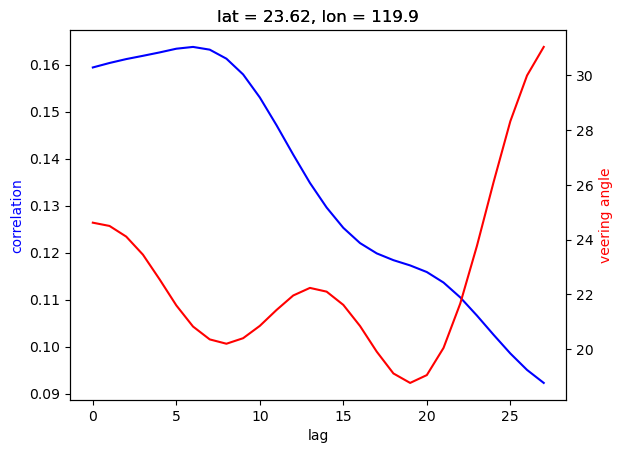

In [145]:
fig, ax1 = plt.subplots(1, 1)
ax2 = ax1.twinx()
corr_vel_wind.sel(lat=23.625, lon=119.875).r.plot(ax=ax1, color='b')
corr_vel_wind.sel(lat=23.625, lon=119.875).va.plot(ax=ax2, color='r')
ax1.set_ylabel('correlation', color='b')
ax2.set_ylabel('veering angle', color='r')

# Coherence

https://stackoverflow.com/questions/51258394/compute-coherence-in-python

In [60]:
lat = 23.625
lon = 119.875

data1 = velocity.sel(lat=lat,lon=lon).u.data + 1j*velocity.sel(lat=lat,lon=lon).v.data
data2 = wind.sel(lat=lat,lon=lon).u10.data + 1j*wind.sel(lat=lat,lon=lon).v10.data

In [25]:
data1, mean = demean_xarray(velocity.sel(lat=lat, lon=lon).u_filtered + 
                           1j*velocity.sel(lat=lat, lon=lon).v_filtered,
                            dim='time')
data1 = polynomial_detrend(data1)[:,0]

data2,mean = demean_xarray(wind.sel(lat=lat,lon=lon).taux + 1j*wind.sel(lat=lat,lon=lon).tauy,dim='time')
data2 = polynomial_detrend(data2)[:,0]

In [30]:
velocity['u_demeaned'], velocity['u_mean'] = demean_xarray(velocity.u,
                                                           dim='time')
velocity['v_demeaned'], velocity['v_mean'] = demean_xarray(velocity.v,
                                                           dim='time')

velocity['u_detrended'], velocity['u_trend'] = detrend_xarray(velocity['u_demeaned'])
velocity['v_detrended'], velocity['v_trend'] = detrend_xarray(velocity['v_demeaned'])

wind['u_demeaned'], wind['u_mean'] = demean_xarray(wind.taux, dim='time')
wind['v_demeaned'], wind['v_mean'] = demean_xarray(wind.tauy, dim='time')

wind['u_detrended'], wind['u_trend'] = detrend_xarray(wind['u_demeaned'])
wind['v_detrended'], wind['v_trend'] = detrend_xarray(wind['v_demeaned'])

In [15]:
coherence = xarray_coherence(velocity.u_filtered + 1j*velocity.v_filtered,
                             wind.taux + 1j*wind.tauy,
                             nperseg=512)

In [16]:
coherence.coherence.max(dim='freq').plot()

In [17]:
coherence_ssh = xarray_coherence(velocity_1D.u_filtered + 1j*velocity_1D.v_filtered,
                             ssh.ugos + 1j*ssh.vgos,
                             nperseg=128)

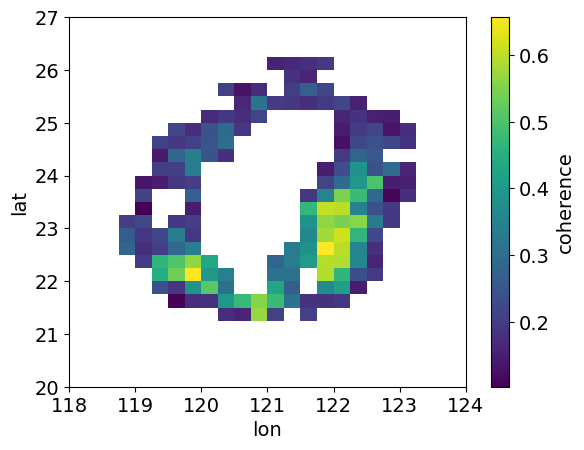

In [18]:
coherence_ssh.coherence.max(dim='freq').plot()

In [20]:
2*np.pi/1e-4/60/60/24

0.7272205216643041

In [9]:
freq_cohmax = coherence.isel(freq=xr.DataArray(coherence.coherence.data.argmax(axis=0),dims=['lat', 'lon'])).freq

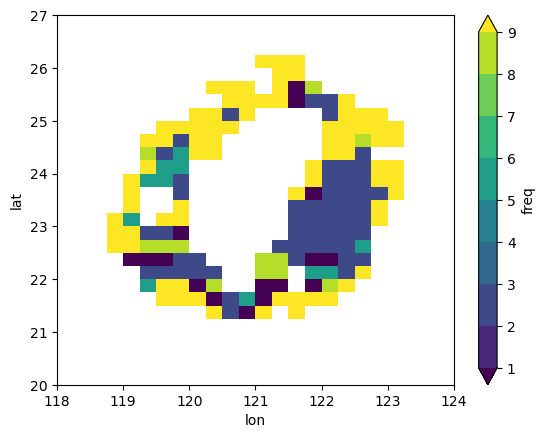

In [12]:
abs(freq_cohmax.where(freq_cohmax != -0.5)*365).plot(levels=np.arange(1, 10))

In [140]:
0.01*365

3.65

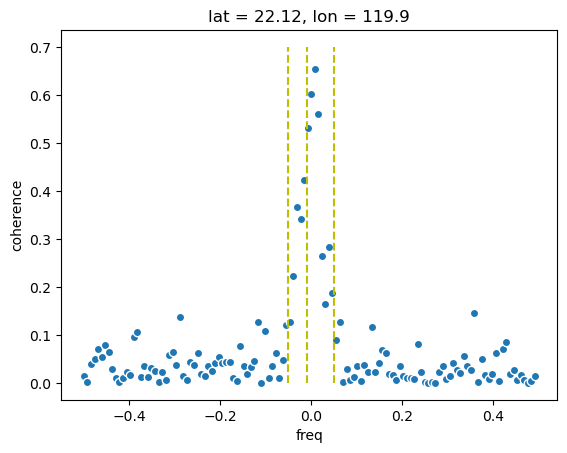

In [31]:
xr.plot.scatter(coherence.sel(lon=119.875,lat=22.125),x='freq',y='coherence')
ymin,ymax = 0,0.7
plt.vlines([-0.05, -0.01, 0.05],ymin,ymax,color=['y'],linestyle='--',label='seasonal')


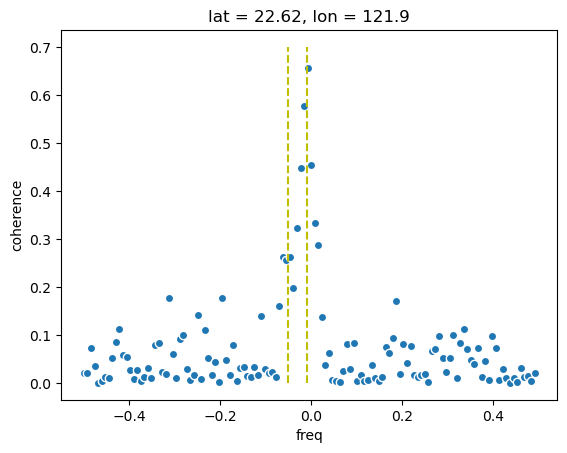

In [141]:
xr.plot.scatter(coherence.sel(lon=121.875,lat=22.625),x='freq',y='coherence')
ymin,ymax = 0,0.7
plt.vlines([-0.05,-0.01],ymin,ymax,color=['y'],linestyle='--',label='seasonal')


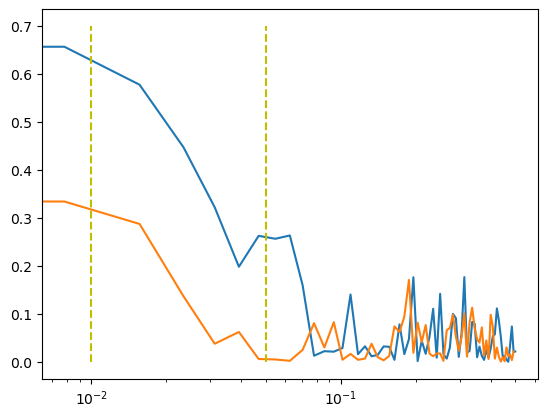

In [147]:
plt.semilogx(-coherence.freq, coherence.sel(lon=121.875, lat=22.625).coherence)
plt.semilogx(coherence.freq, coherence.sel(lon=121.875, lat=22.625).coherence)

ymin, ymax = 0, 0.7
plt.vlines([0.05, 0.01], ymin, ymax, color=['y'], linestyle='--', label='seasonal')


In [32]:
0.04*365

14.6

In [33]:
365/14

26.071428571428573

In [63]:
nperseg = 1024
p11=crossSpectrum(data1,data1,nperseg=nperseg)
p22=crossSpectrum(data2,data2,nperseg=nperseg)
p12=crossSpectrum(data1,data2,nperseg=nperseg)

# coherence
coh=np.abs(p12[:,0])**2/p11[:,0].real/p22[:,0].real

freq = p11[:,1]

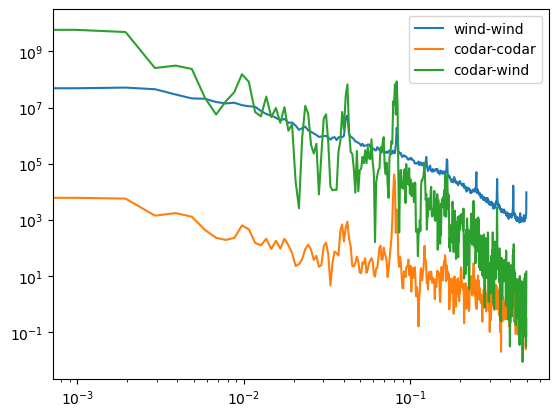

In [65]:
plt.loglog(freq,p22[:,0],label='wind-wind')
plt.loglog(freq,p11[:,0],label='codar-codar')
plt.loglog(freq,abs(p12[:,0])**2,label='codar-wind')
plt.legend()

(-2.5, 2.5)

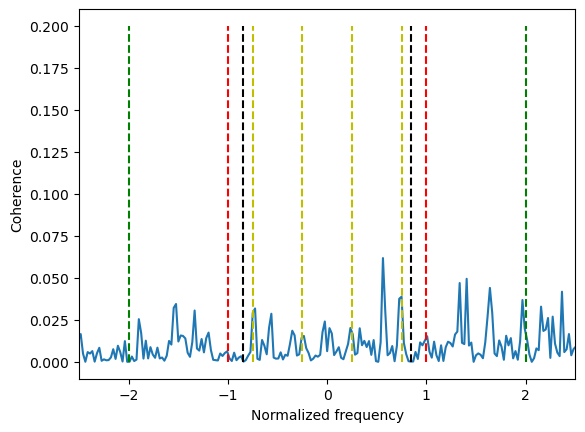

In [66]:
plt.plot((freq*24),coh)
plt.xlabel('Normalized frequency')
plt.ylabel('Coherence')
f_coriolis = 2*7.29e-5*np.sin(25/180*np.pi)/2/np.pi*3600*24

ymin,ymax = 0,0.2
plt.vlines([-f_coriolis,f_coriolis],ymin,ymax,color=['k'],linestyle='--',label='f')
plt.vlines([-1,1],ymin,ymax,color=['r'],linestyle='--',label='diurnal')
plt.vlines([-2,2],ymin,ymax,color=['g'],linestyle='--',label='semidiurnal')
plt.vlines([-0.25,0.25],ymin,ymax,color=['y'],linestyle='--',label='seasonal')
plt.vlines([-0.75,0.75],ymin,ymax,color=['y'],linestyle='--',label='seasonal')


plt.xlim([-2.5,2.5])

In [370]:
nperseg = 2048*2
freq,cf,ps,psd,t = nufft(data2[:nperseg],xarray_apply=False)

psd = np.expand_dims(psd,axis=-1)
for ind in np.arange(0.5,int(43824/nperseg),0.5):
    xp = data1[int(ind * nperseg): int((ind + 1)*nperseg)]
    xp = xp*np.hanning(nperseg)

    # Do FFT
    freqi,cfi,psi,psdi,ti = nufft(xp,xarray_apply=False)
    psdi = np.expand_dims(psdi,axis=-1)
    psd = np.concatenate((psd,psdi),axis=-1)
    
psd_mean = np.mean(psd,axis=-1)

f,pxx = scipy.signal.welch(data2,window=np.hanning(nperseg),nperseg=nperseg)
freqx,cfx,psx,psdx,tx = nufft(data2,xarray_apply=False)


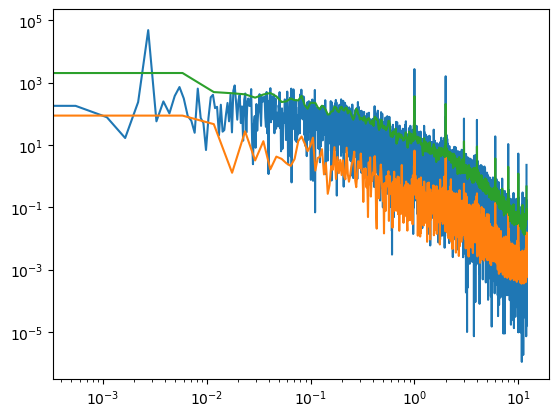

In [371]:
plt.loglog(freqx*24,psdx)
plt.loglog(freq*24,psd_mean)

plt.loglog(f*24,pxx)


# plt.ylim([1e-12,1e-3])
# plt.scatter(2.8e-3,1)

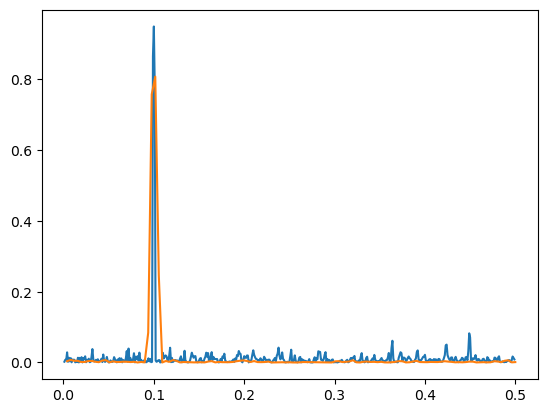

In [72]:
import numpy
x = numpy.linspace(-2500, 2500, 50000)
noise = numpy.random.random(len(x))
y = 10*numpy.sin(2*numpy.pi*x)
y2 = 5*numpy.sin(2*numpy.pi*x)+5+noise*50

p11, freq = crossSpectrum(y, y, nperseg=1000)
p22, freq = crossSpectrum(y2, y2, nperseg=1000)
p12, freq = crossSpectrum(y, y2, nperseg=1000)

# coherence
coh=numpy.abs(p12)**2/p11.real/p22.real
f,pxx = scipy.signal.coherence(y,y2)
plt.plot(freq[freq > 0], coh[freq > 0])
plt.plot(f[f > 0], pxx[f > 0])


# Taiwan Strait Mask

In [5]:
nan_mask = ~np.isnan(velocity.u)
data_coverage = np.sum(nan_mask, axis=0)/len(velocity.time)
velocity['coverage'] = data_coverage

lat = velocity.lat
lon = velocity.lon

mask = lat.where(lat > 22.5)/lat
mask = mask.where(lon < 122)
mask = mask.where(velocity.coverage != 0)
mask[10:42, 23:] = np.nan

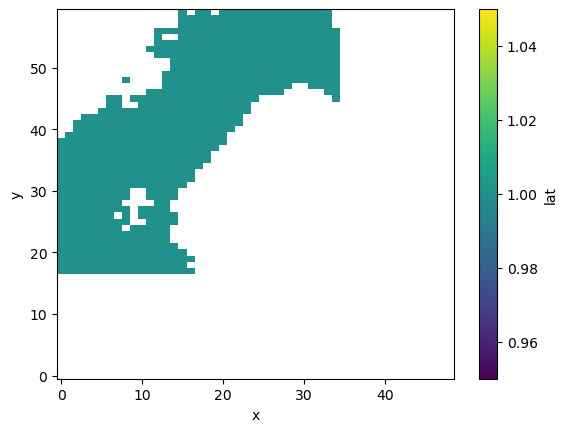

In [34]:
mask.plot()